In [ ]:
#!pip install lightgbm

In [ ]:
#!pip install CatBoost

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import BayesianRidge, SGDRegressor, Lasso

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization 
from keras.optimizers import Adam

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

## Data Understanding

### Load Dataset

In [2]:
# Import the data
# goal: predict scalar_coupling_const by its structure
# We will use train set and structures
train_df = pd.read_csv('Data/train.csv')
structures_df = pd.read_csv('Data/structures.csv')

In [3]:
# Observe traindf
print(train_df.shape)
print('')
print(train_df.nunique())
print('')
print(train_df.columns)
train_df.head()

(4659076, 6)

id                          4659076
molecule_name                 85012
atom_index_0                     28
atom_index_1                     29
type                              8
scalar_coupling_constant    2183446
dtype: int64

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [4]:
# Observe structures_df
print(structures_df.shape)
print('')
print(structures_df.nunique())
print('')
print(structures_df.columns)
structures_df.head()

(2358875, 6)

molecule_name     130789
atom_index            29
atom                   5
x                2358802
y                2358808
z                2358792
dtype: int64

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z'], dtype='object')


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### Exploratory Data Analysis (EDA)

#### Scalar Coupling Constant (Target)

Text(0, 0.5, 'Counts')

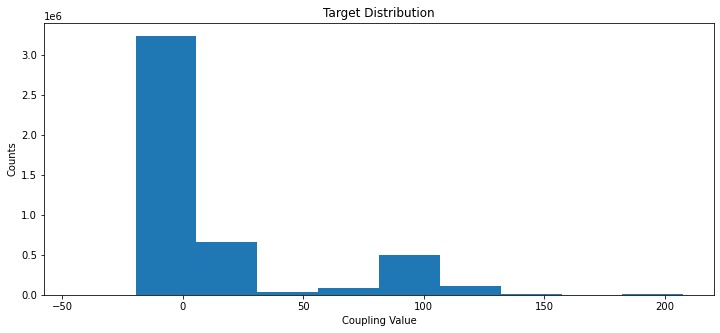

In [5]:
# Check the Distribution of Target Variable
fig, ax = plt.subplots(figsize=(12,5))

ax.hist(train_df['scalar_coupling_constant'])
ax.set_title('Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

#### Types of Bond

Text(0, 0.5, 'Counts')

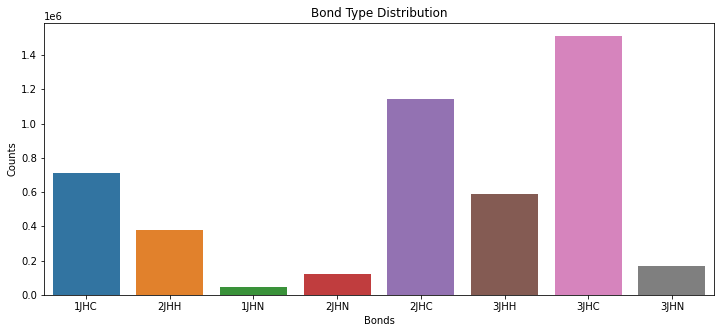

In [6]:
# Check the type of bonds
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='type', data=train_df)
ax.set_title('Bond Type Distribution')
ax.set_xlabel('Bonds')
ax.set_ylabel('Counts')

Multiple bond type might cause the trouble later on the modeling. Therefore we will create a subset based on each model type in later part.

#### Atom Index

Text(0, 0.5, 'Counts')

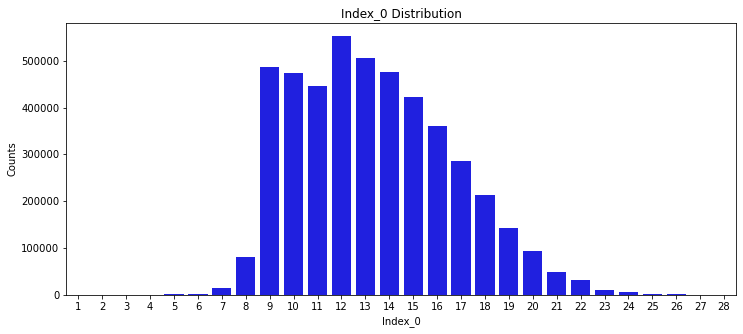

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_0', data=train_df, color = 'blue')
ax.set_title('Index_0 Distribution')
ax.set_xlabel('Index_0')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

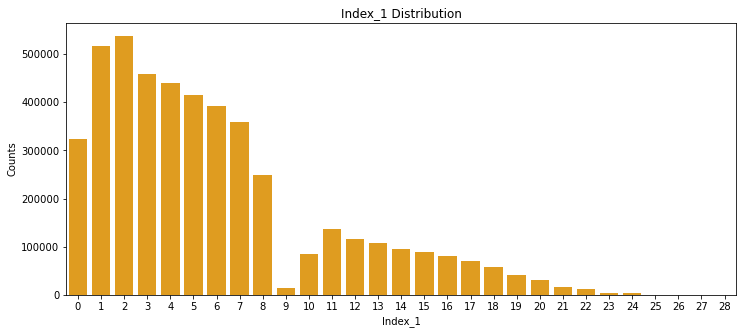

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_1', data=train_df, color = 'orange')
ax.set_title('Index_1 Distribution')
ax.set_xlabel('Index_1')
ax.set_ylabel('Counts')

### Feature Engineering

#### Merge Train and Structure

This merging technique has been sourced from: https://www.kaggle.com/inversion/atomic-distance-benchmark

In [9]:
def map_atom_info(df, atom_idx):
    '''
    
    '''
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [10]:
# Merge train and structures
train_df2 = map_atom_info(train_df, 0)
train_df2 = map_atom_info(train_df2, 1)
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [11]:
# check nan after merging
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dtype: int64

#### Distance between Atoms

In [12]:
# Calculate the 3D distance between atom
train_df2['distance'] = ((train_df2['x_0']-train_df2['x_1'])**2 +
(train_df2['y_0']-train_df2['y_1'])**2 + (train_df2['z_0']-train_df2['z_1'])**2)**0.5

train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


In [13]:
train_df2['dist_to_type_mean'] = train_df2['distance'] / train_df2.groupby('type')['distance'].transform('mean')
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132


In [14]:
train_df2[f'molecule_type_distance_mean'] = train_df2.groupby(['molecule_name', 'type'])['distance'].transform('mean')
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,molecule_type_distance_mean
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953,0.999134,1.091950
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120,1.004647,1.783146
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147,1.004663,1.783146
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157,1.004668,1.783146
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952,0.999132,1.091950


Before we enter train test split, we will make a subset of train_df2 based on the bond type.

According to the bar plot in 'Type of Bond' section, we know that there are 8 types of bond:

- {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}

In [15]:
train_df2['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [16]:
def subset(btype):
    '''
    This function creates and returns subset of the train_df2. 
    It will locate the rows with certain bond type and generate subset.
    
    input: btype
    Options for btype: {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}
    
    output: subset in form of dataframe
    '''
    df = train_df2.loc[train_df2['type'] == btype]
    
    return df

In [17]:
c1_df = subset('1JHC')
n1_df = subset('1JHN')
c2_df = subset('2JHC')
h2_df = subset('2JHH')
n2_df = subset('2JHN')
c3_df = subset('3JHC')
h3_df = subset('3JHH')
n3_df = subset('3JHN')

In [18]:
# check if the subset are well splitted
print('c1')
print(c1_df['type'].value_counts())
print('')
print('c2')
print(c2_df['type'].value_counts())
print('')
print('c3')
print(c3_df['type'].value_counts())
print('')
print('n1')
print(n1_df['type'].value_counts())
print('')
print('n2')
print(n2_df['type'].value_counts())
print('')
print('n3')
print(n3_df['type'].value_counts())
print('')
print('h2')
print(h2_df['type'].value_counts())
print('')
print('h3')
print(h3_df['type'].value_counts())

c1
1JHC    709133
Name: type, dtype: int64

c2
2JHC    1140867
Name: type, dtype: int64

c3
3JHC    1511207
Name: type, dtype: int64

n1
1JHN    43680
Name: type, dtype: int64

n2
2JHN    119059
Name: type, dtype: int64

n3
3JHN    166613
Name: type, dtype: int64

h2
2JHH    377988
Name: type, dtype: int64

h3
3JHH    590529
Name: type, dtype: int64


#### Train Test Split

We will split the train_df2 into X and y. We will exclude columns id and molecule_name 
- X: All columns else than trarget variable(scalar_coupling_constant), id, molecule_name, and type
    - We will exclude columns id and molecule_name since those two does not contribute to the scalar coupling constant.
    - type will be dropped since all the df are now the subset with same bond type
- y: target variable (scalar_coupling_constant)

We will also create function for whole process since we have to run for each subset.

Moreover, we will conduct train test split twice to create train set, validation set, and test set.The ratio for this split will be 80% for train, 10% for validation and test, which is a common ratio.

In [19]:
def ttv_split(df):
    '''
    This function splits the set of dataframe into train, validation, and test set with ration of 80:10:10.
    '''
    X = df.drop(columns = ['id', 'molecule_name', 'scalar_coupling_constant','type'])
    y = df[['scalar_coupling_constant']]
    
    # Split into train and test
    # ratio train 90% : test 10%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state = 1)
    
    # Split into train and val
    # ratio train 80% : val 10% : test 10%
    # to achieve this test_size should be 1/9
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state =1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [20]:
c1_X_train, c1_X_test, c1_X_val, c1_y_train, c1_y_test, c1_y_val = ttv_split(c1_df)
c2_X_train, c2_X_test, c2_X_val, c2_y_train, c2_y_test, c2_y_val = ttv_split(c2_df)
c3_X_train, c3_X_test, c3_X_val, c3_y_train, c3_y_test, c3_y_val = ttv_split(c3_df)
n1_X_train, n1_X_test, n1_X_val, n1_y_train, n1_y_test, n1_y_val = ttv_split(n1_df)
n2_X_train, n2_X_test, n2_X_val, n2_y_train, n2_y_test, n2_y_val = ttv_split(n2_df)
n3_X_train, n3_X_test, n3_X_val, n3_y_train, n3_y_test, n3_y_val = ttv_split(n3_df)
h2_X_train, h2_X_test, h2_X_val, h2_y_train, h2_y_test, h2_y_val = ttv_split(h2_df)
h3_X_train, h3_X_test, h3_X_val, h3_y_train, h3_y_test, h3_y_val = ttv_split(h3_df)

In [21]:
c1_X_train.head()

,atom_index_0,atom_index_1,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,molecule_type_distance_mean
1794965,9,0,H,0.255344,2.312081,0.654561,C,-0.695524,1.794885,0.500323,1.093358,1.000419,1.094782
3194028,9,0,H,0.919415,2.042258,-0.006993,C,-0.065870,1.565067,-0.063755,1.096229,1.003046,1.096434
4002445,11,0,H,-0.096303,1.323997,1.330618,C,0.144958,1.163510,0.278043,1.091731,0.998930,1.095134
1571087,15,7,H,3.359409,3.561537,-2.932070,C,3.117779,3.009572,-2.027701,1.086707,0.994334,1.091310
4323126,11,0,H,-0.876799,1.893361,0.697739,C,-0.120853,1.547940,-0.014709,1.094693,1.001641,1.098078


In [22]:
c1_X_val.head()

,atom_index_0,atom_index_1,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance,dist_to_type_mean,molecule_type_distance_mean
3488947,14,2,H,1.663497,0.079107,1.509084,C,0.718083,-0.440318,1.328619,1.093699,1.000731,1.096339
1368134,13,6,H,3.088595,2.403053,1.298326,C,2.562035,2.704758,0.389108,1.093146,1.000225,1.091555
2496347,9,0,H,0.516420,2.155714,0.118905,C,-0.332618,1.491548,-0.064319,1.093413,1.000470,1.093251
2883908,11,0,H,-0.556952,1.868895,0.938078,C,-0.024147,1.465134,0.055208,1.107413,1.013279,1.099727
389129,11,2,H,-2.009111,0.068135,0.407309,C,-1.317965,-0.502299,-0.226471,1.097613,1.004313,1.098167


Great! Train test split was successful.

#### Preprocessing Pipeline

First, we will divide up the columns into numerical and categorical.

In [23]:
# Create a train_df3
# exclude scalar_coupling_constant, id, molecule_name, and type
train_df3 = train_df2.drop(columns=['scalar_coupling_constant', 'id', 'molecule_name', 'type'])

In [24]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659076 entries, 0 to 4659075
Data columns (total 13 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   atom_index_0                 int64  
 1   atom_index_1                 int64  
 2   atom_0                       object 
 3   x_0                          float64
 4   y_0                          float64
 5   z_0                          float64
 6   atom_1                       object 
 7   x_1                          float64
 8   y_1                          float64
 9   z_1                          float64
 10  distance                     float64
 11  dist_to_type_mean            float64
 12  molecule_type_distance_mean  float64
dtypes: float64(9), int64(2), object(2)
memory usage: 497.6+ MB


In [25]:
# initialize lists of columns
num_cols = []
cat_cols = []

# num = any columns with numerical value
# cat = everything else
for c in train_df3.columns:
    if train_df3[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [26]:
num_cols

['atom_index_0',
 'atom_index_1',
 'x_0',
 'y_0',
 'z_0',
 'x_1',
 'y_1',
 'z_1',
 'distance',
 'dist_to_type_mean',
 'molecule_type_distance_mean']

In [27]:
cat_cols

['atom_0', 'atom_1']

First, define the transformers for each column type using pipeline.

In [28]:
# Define transformers using pipeline
num_transformer = Pipeline(steps=[('minmaxscaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

Then, combine transformers into preprocessor using ColumnTransformer.

In [29]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

Finally, we will fit the preprocessor to X_train

In [30]:
preprocessor.fit(c1_X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['atom_index_0', 'atom_index_1', 'x_0', 'y_0',
                                  'z_0', 'x_1', 'y_1', 'z_1', 'distance',
                                  'dist_to_type_mean',
                                  'molecule_type_distance_mean']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['atom_0', 'atom_1'])])

## Modeling

There are multiple options for solving the regression problem. 
- Linear Regression
- Bayesian Ridge
- SGD Regressor
- Robust Regression
- Gaussian Process Regression (X not enough memory)
- Random Forest 
- MLP Regression
- Neural Networks

Exception:
- Support Vector Machine
    - Since our dataset is huge, support vector machine will take too long for modelling.
    
    
Out of those models, most simple model is Linear Regression. To understand our baseline, we will start off with the Linear Regression Model.

### 1. First Simple Model

Our first simple model will be the linear regression model.

In [34]:
def fit_and_eval(regressor, X_train, y_train, X_val, y_val):
    model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', regressor)
                        ])
    model.fit(X_train, y_train)
    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Train MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')

#### 1.1 1JHC

Result Report

Train R2 Score: 0.5476881814052119
Validation R2 Score: 0.5481864291031209

Train RMSE: 12.282147383969322
Validation RMSE: 12.39634436188255

Train MAE: 8.575081973952152
Validation MAE: 8.627502801380281


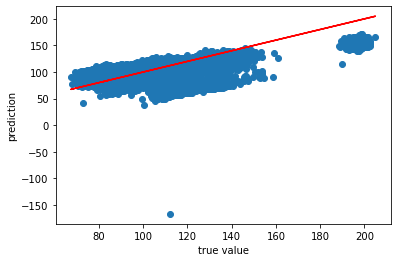

In [35]:
fit_and_eval(LinearRegression(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 1.2 1JHN

Result Report

Train R2 Score: 0.7824424799092586
Validation R2 Score: 0.7758876531021017

Train RMSE: 5.079397096091276
Validation RMSE: 5.203475063605823

Train MAE: 3.4361804758920584
Validation MAE: 3.578440357073757


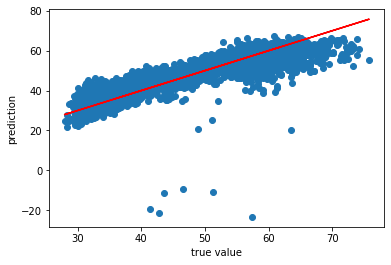

In [36]:
fit_and_eval(LinearRegression(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 1.3 2JHC

Result Report

Train R2 Score: 0.09902292610684849
Validation R2 Score: 0.09815992330402545

Train RMSE: 4.295119158330383
Validation RMSE: 4.305410188183276

Train MAE: 2.6578739244008336
Validation MAE: 2.6559632399179645


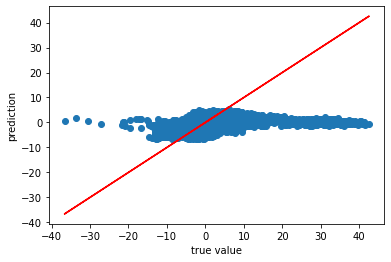

In [37]:
fit_and_eval(LinearRegression(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 1.4 2JHH

Result Report

Train R2 Score: 0.3138402056003695
Validation R2 Score: 0.31059583459202145

Train RMSE: 3.2923380601079324
Validation RMSE: 3.347295728026217

Train MAE: 1.9714525887551078
Validation MAE: 1.993961397543001


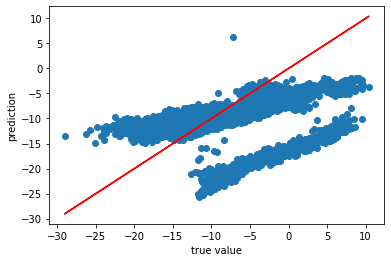

In [38]:
fit_and_eval(LinearRegression(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 1.5 2JHN

Result Report

Train R2 Score: 0.15237446156079493
Validation R2 Score: 0.1679868687902929

Train RMSE: 3.3869235421899746
Validation RMSE: 3.3456452034166855

Train MAE: 2.6684383846116964
Validation MAE: 2.6335231800297363


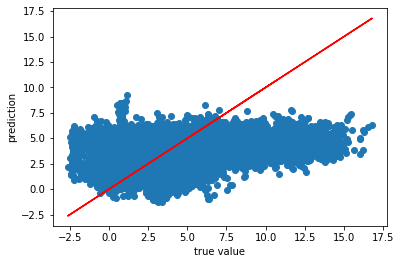

In [39]:
fit_and_eval(LinearRegression(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 1.6 3JHC

Result Report

Train R2 Score: 0.11699676047287721
Validation R2 Score: 0.11502693231911221

Train RMSE: 2.889539882324746
Validation RMSE: 2.8955387991111694

Train MAE: 2.2749916377039328
Validation MAE: 2.278705071786694


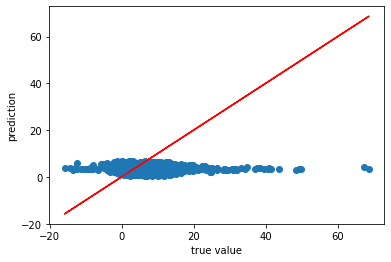

In [40]:
fit_and_eval(LinearRegression(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 1.7 3JHH

Result Report

Train R2 Score: 0.10174968520314764
Validation R2 Score: 0.10303344524956026

Train RMSE: 3.5128119190041955
Validation RMSE: 3.5028903793275763

Train MAE: 2.927618429099685
Validation MAE: 2.919624564713082


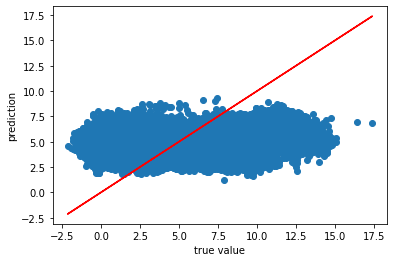

In [41]:
fit_and_eval(LinearRegression(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 1.8 3JHN

Result Report

Train R2 Score: 0.11703824202373125
Validation R2 Score: 0.11826059926058441

Train RMSE: 1.239813482864774
Validation RMSE: 1.2466631806378998

Train MAE: 0.9125810066318585
Validation MAE: 0.915058085395027


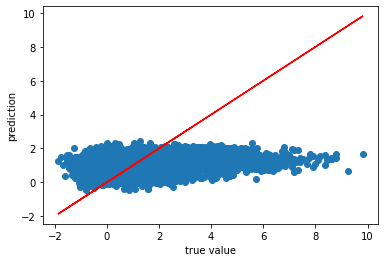

In [42]:
fit_and_eval(LinearRegression(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

#### 1.9 Overall Evaluation

Evaluation on the validation sets:
- R2 score: very low (mostly below 0.1 except bond types 1JHC and 1JHN)
- RMSE: very high / ranges from 1.26 to 12.4
- MAE: varies / ranges from 0.93 to 8.66

Our linear regression models results proves that the most of the bond type cannot be explained with simple linear regression. Only two reasonable R_squared value is that of 1JHC and 1JHN. However, they are both below 0.8 and has the high error values which proves that we need to try out different regression models.

##### 1.9.1 Type with R2 >= 0.5

- 1JHC
    - Train R2 Score: 0.5463159135570067
    - Validation R2 Score: 0.5466896074871468

    - Train RMSE: 12.300764664124433
    - Validation RMSE: 12.41686142345409

    - Train MAE: 8.604505167515708
    - Validation MAE: 8.655867320505603

- 1JHN
    -

### 2. Random Forest Regressor

In [43]:
# parameters for gridsearch
rf_params={#'classifier__criterion':['squared_error', 'absolute_error', 'poisson'],
           'classifier__n_estimators':[100, 200, 300],
           #'classifier__min_samples_leaf':[1, 8, 12],
           #'classifier__max_features':['auto','log2', 'sqrt'],
           'classifier__max_depth':[8, 10, 12],
           #'classifier__max_leaf_nodes':[10, 20, 30], 
           'classifier__min_samples_split' : [2,4,8]
           #'classifier__bootstrap': [True, False]
       }

In [44]:
def rf_tuning(X_train, y_train, params):
    rf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor())
                        ])
    rf.fit(X_train, y_train)
    grid_rf = GridSearchCV(rf, param_grid=params, scoring= ['neg_root_mean_squared_error'])
    output_rf = grid_rf.fit(X_train, y_train)
    print('Best Param:{0}, Best score:{1:.3f}'.format(grid_rf.best_params_, 
                                               grid_rf.best_score_))

#### 2.1 1JHC

Result Report

Train R2 Score: 0.9872155529387672
Validation R2 Score: 0.9092360145072086

Train RMSE: 2.064887100750385
Validation RMSE: 5.55610923164385

Train MAE: 1.372569891742537
Validation MAE: 3.7075161770877396


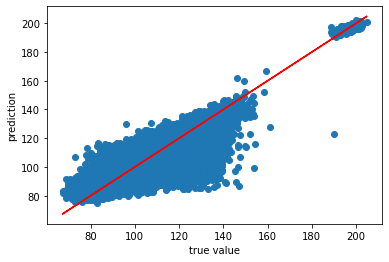

In [45]:
fit_and_eval(RandomForestRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 2.2 1JHN

Result Report

Train R2 Score: 0.9897930697624436
Validation R2 Score: 0.9256213612258684

Train RMSE: 1.1002026577084318
Validation RMSE: 2.997676055014608

Train MAE: 0.7144117421588828
Validation MAE: 1.976640576694139


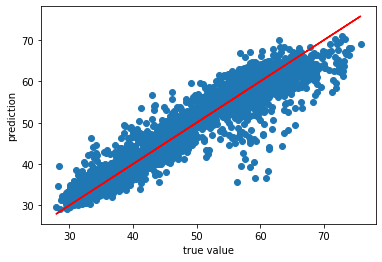

In [46]:
fit_and_eval(RandomForestRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 2.3 2JHC

Result Report

Train R2 Score: 0.9407286361168674
Validation R2 Score: 0.57066116807527

Train RMSE: 1.1016428172834352
Validation RMSE: 2.9706388326541107

Train MAE: 0.6178633214910323
Validation MAE: 1.6618008396642914


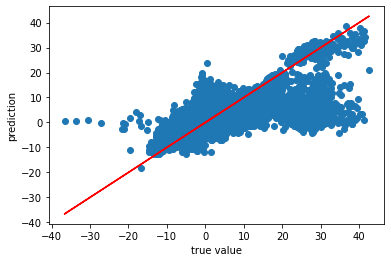

In [47]:
fit_and_eval(RandomForestRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 2.4 2JHH 

Result Report

Train R2 Score: 0.9785467202208986
Validation R2 Score: 0.8443168851793232

Train RMSE: 0.5821550073823646
Validation RMSE: 1.5906619326501275

Train MAE: 0.33557612072267606
Validation MAE: 0.9109646304116511


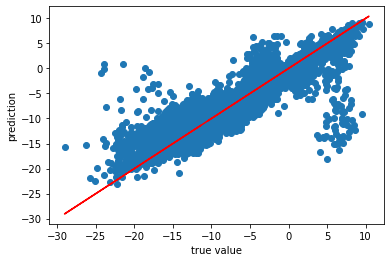

In [48]:
fit_and_eval(RandomForestRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 2.5 2JHN

Result Report

Train R2 Score: 0.9605330927760112
Validation R2 Score: 0.717664622318278

Train RMSE: 0.7308359858583374
Validation RMSE: 1.94893539583154

Train MAE: 0.4511446430258172
Validation MAE: 1.2180655990299007


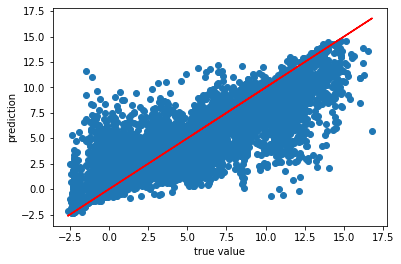

In [49]:
fit_and_eval(RandomForestRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 2.6 3JHC

Result Report

Train R2 Score: 0.9493986875824278
Validation R2 Score: 0.6357851262131096

Train RMSE: 0.6917169775716049
Validation RMSE: 1.8575614964233103

Train MAE: 0.46179047113399474
Validation MAE: 1.2476646603487935


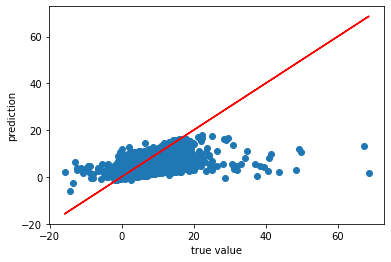

In [50]:
fit_and_eval(RandomForestRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 2.7 3JHH 

Result Report

Train R2 Score: 0.9737160527494015
Validation R2 Score: 0.8136658219288883

Train RMSE: 0.6008990288047162
Validation RMSE: 1.596557935346888

Train MAE: 0.3869638415807654
Validation MAE: 1.0358189574697307


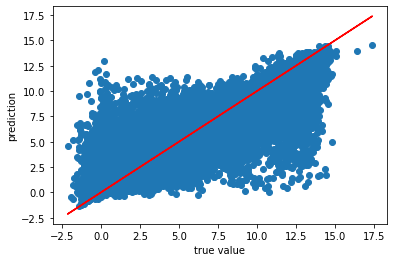

In [51]:
fit_and_eval(RandomForestRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 2.8 3JHN

Result Report

Train R2 Score: 0.9494254039176346
Validation R2 Score: 0.6458257887072756

Train RMSE: 0.2967232787988896
Validation RMSE: 0.7901098516203722

Train MAE: 0.18632215016062842
Validation MAE: 0.4996453404687313


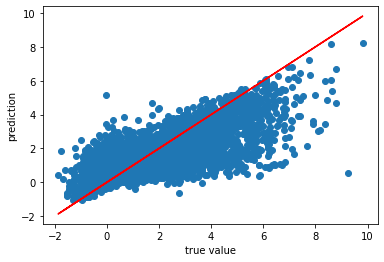

In [52]:
fit_and_eval(RandomForestRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

#### 2.9 Overall Evaluation
We can see there is an overfitting for every bond types with no parameters added to the Random Forest Regressor. However, the results are more promising than the simple linear regression. With hyper paramter tuning, there is a possibility of enhance the performance on validation set while reducing the error scores.

### 3. XGB Regressor


#### 3.1 1JHC

Result Report

Train R2 Score: 0.8916095526450071
Validation R2 Score: 0.8868267734490544

Train RMSE: 6.012441185289735
Validation RMSE: 6.204200798371347

Train MAE: 4.211623626487838
Validation MAE: 4.327922435249269


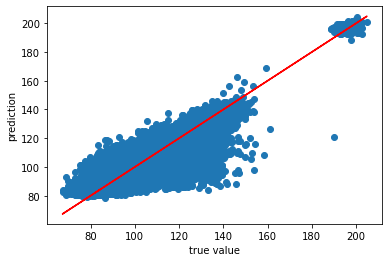

In [53]:
fit_and_eval(XGBRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 3.2 1JHN

Result Report

Train R2 Score: 0.9537228578334312
Validation R2 Score: 0.9229985496978009

Train RMSE: 2.3426552529471416
Validation RMSE: 3.050071627738152

Train MAE: 1.689789643042603
Validation MAE: 2.142495349153233


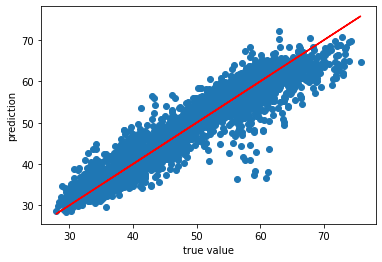

In [54]:
fit_and_eval(XGBRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 3.3 2JHC

Result Report

Train R2 Score: 0.46674833655561554
Validation R2 Score: 0.43610152714901496

Train RMSE: 3.304337934659892
Validation RMSE: 3.4044756157877947

Train MAE: 2.039591206708229
Validation MAE: 2.08268591725206


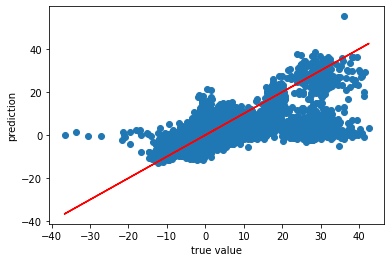

In [55]:
fit_and_eval(XGBRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 3.4 2JHH

Result Report

Train R2 Score: 0.8434996794542531
Validation R2 Score: 0.8113366154497826

Train RMSE: 1.5723506509344234
Validation RMSE: 1.7510596568902899

Train MAE: 1.0310116537094063
Validation MAE: 1.0914180298915512


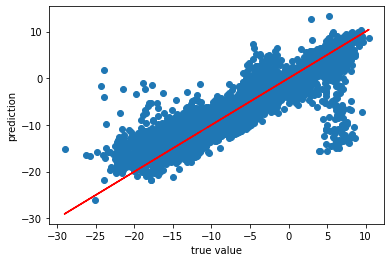

In [56]:
fit_and_eval(XGBRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 3.5 2JHN

Result Report

Train R2 Score: 0.7054921245159431
Validation R2 Score: 0.6178998333415908

Train RMSE: 1.9964196351971812
Validation RMSE: 2.267270861442024

Train MAE: 1.4357611407747684
Validation MAE: 1.6022231691721738


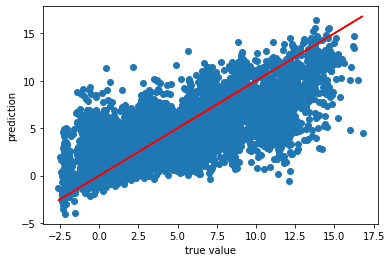

In [57]:
fit_and_eval(XGBRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 3.6 3JHC

Result Report

Train R2 Score: 0.4514472880683419
Validation R2 Score: 0.4354169369930041

Train RMSE: 2.2774913065218834
Validation RMSE: 2.3127478422627035

Train MAE: 1.6716606769955575
Validation MAE: 1.6927835599132317


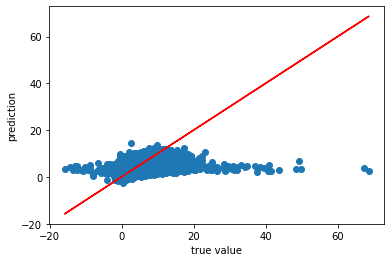

In [58]:
fit_and_eval(XGBRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 3.7 3JHH

Result Report

Train R2 Score: 0.757544742502219
Validation R2 Score: 0.7418610233940632

Train RMSE: 1.825038420517595
Validation RMSE: 1.8791662923448575

Train MAE: 1.29971779109768
Validation MAE: 1.3288802188108686


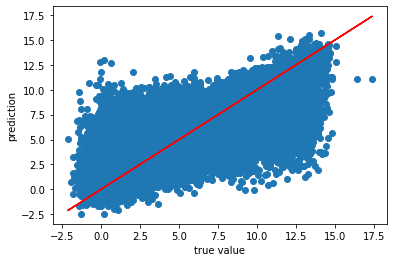

In [59]:
fit_and_eval(XGBRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 3.8 3JHN

Result Report

Train R2 Score: 0.5863991188025136
Validation R2 Score: 0.5030931252337452

Train RMSE: 0.8485474555620846
Validation RMSE: 0.9358721246695515

Train MAE: 0.5877456005653909
Validation MAE: 0.6378659534391476


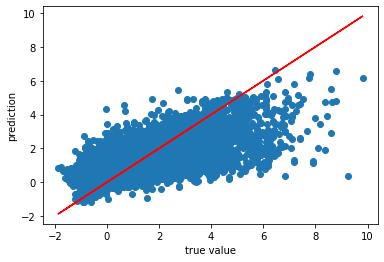

In [60]:
fit_and_eval(XGBRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 4. LGBM Regressor


In [61]:
def tune(regressor, X_train, y_train, X_val, y_val, parameter):
    model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', regressor)
                        ])
    grid_model = GridSearchCV(model, param_grid=parameter, refit = False, cv =10, scoring=['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error'])
    output = grid_model.fit(X_train, y_train)
    print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_model.best_params_, 
                                                  grid_model.best_score_))

In [62]:
lgbm_params={
           'regressor__objective':['regression', 'regression_l1', 'huber'],
           'regressor__n_estimators':[100, 500, 1000],
           'regressor__num_iterations':[100,1000],
           'regressor__learning_rate':[0.1, 0.01],
           'regressor__boosting_type':['gbdt','dart']
       }

#### 4.1 1JHC

Result Report

Train R2 Score: 0.8739231810320833
Validation R2 Score: 0.8740285792052169

Train RMSE: 6.484447195210262
Validation RMSE: 6.545608260579729

Train MAE: 4.535556092942604
Validation MAE: 4.57371293985811


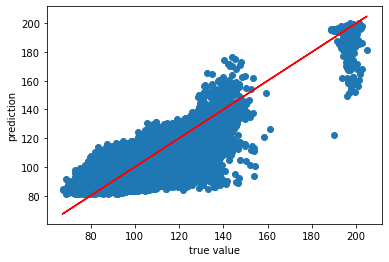

In [63]:
fit_and_eval(LGBMRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 4.2 1JHN

Result Report

Train R2 Score: 0.9295700308819651
Validation R2 Score: 0.9153500499635835

Train RMSE: 2.8900400782620634
Validation RMSE: 3.197966712901424

Train MAE: 2.067092684461615
Validation MAE: 2.2556944149071385


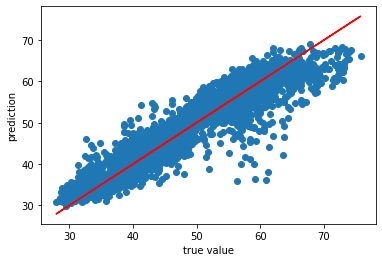

In [64]:
fit_and_eval(LGBMRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 4.3 2JHC

Result Report

Train R2 Score: 0.41532409829627026
Validation R2 Score: 0.40263111652381744

Train RMSE: 3.4599987654465516
Validation RMSE: 3.504056233015917

Train MAE: 2.1588539542109833
Validation MAE: 2.176963292651852


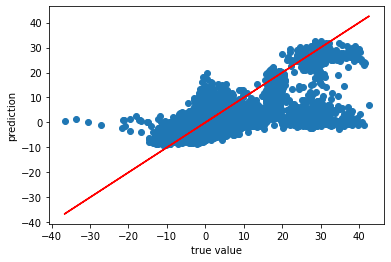

In [65]:
fit_and_eval(LGBMRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 4.4 2JHH

Result Report

Train R2 Score: 0.8137378382329192
Validation R2 Score: 0.7987540366414836

Train RMSE: 1.7153553786617073
Validation RMSE: 1.8085091928434422

Train MAE: 1.1056538646608016
Validation MAE: 1.1308866134329105


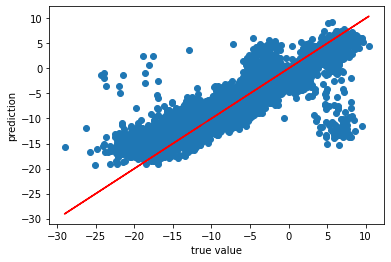

In [66]:
fit_and_eval(LGBMRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 4.5 2JHN

Result Report

Train R2 Score: 0.5961770693465241
Validation R2 Score: 0.5663863747590359

Train RMSE: 2.337754298978947
Validation RMSE: 2.415273148754614

Train MAE: 1.7068871506540522
Validation MAE: 1.7475430933165084


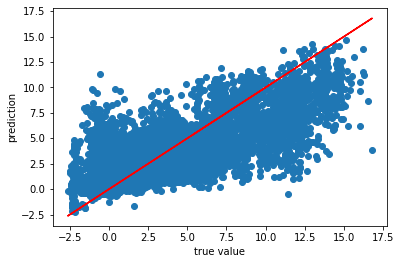

In [67]:
fit_and_eval(LGBMRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 4.6 3JHC

Result Report

Train R2 Score: 0.386194697905628
Validation R2 Score: 0.38251403231105774

Train RMSE: 2.409144570861143
Validation RMSE: 2.4186771852282454

Train MAE: 1.7871415604612244
Validation MAE: 1.792997593711342


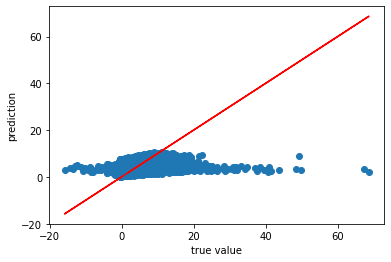

In [68]:
fit_and_eval(LGBMRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 4.7 3JHH

Result Report

Train R2 Score: 0.7102300522784214
Validation R2 Score: 0.7064523358854391

Train RMSE: 1.995183662042962
Validation RMSE: 2.0039078017766627

Train MAE: 1.4463183423875206
Validation MAE: 1.4457990561973508


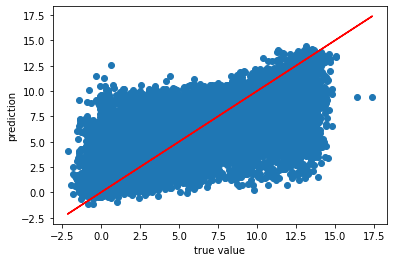

In [69]:
fit_and_eval(LGBMRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 4.8 3JHN

Result Report

Train R2 Score: 0.461107139998161
Validation R2 Score: 0.44054602052048786

Train RMSE: 0.9685825100126251
Validation RMSE: 0.993027310813276

Train MAE: 0.677654981868114
Validation MAE: 0.6883917287214162


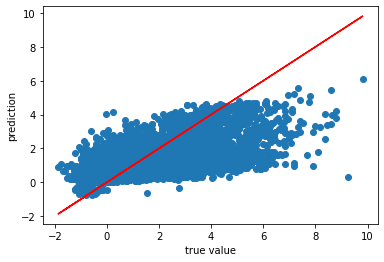

In [70]:
fit_and_eval(LGBMRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 5. CatBoost Regressor

#### 5.1 1JHC

Learning rate set to 0.111502
0:	learn: 16.6284412	total: 203ms	remaining: 3m 22s
1:	learn: 15.2156559	total: 238ms	remaining: 1m 58s
2:	learn: 13.9916484	total: 272ms	remaining: 1m 30s
3:	learn: 12.9397308	total: 305ms	remaining: 1m 16s
4:	learn: 12.0414517	total: 339ms	remaining: 1m 7s
5:	learn: 11.2721455	total: 374ms	remaining: 1m 1s
6:	learn: 10.6246830	total: 408ms	remaining: 57.9s
7:	learn: 10.0646170	total: 445ms	remaining: 55.2s
8:	learn: 9.6110029	total: 481ms	remaining: 52.9s
9:	learn: 9.2197126	total: 513ms	remaining: 50.8s
10:	learn: 8.8958552	total: 549ms	remaining: 49.3s
11:	learn: 8.6274785	total: 583ms	remaining: 48s
12:	learn: 8.4024836	total: 617ms	remaining: 46.8s
13:	learn: 8.2182310	total: 653ms	remaining: 46s
14:	learn: 8.0695037	total: 687ms	remaining: 45.1s
15:	learn: 7.9380058	total: 721ms	remaining: 44.3s
16:	learn: 7.8305273	total: 757ms	remaining: 43.8s
17:	learn: 7.7446878	total: 791ms	remaining: 43.2s
18:	learn: 7.6693744	total: 831ms	remaining: 42.9s
19:

165:	learn: 6.7206637	total: 5.63s	remaining: 28.3s
166:	learn: 6.7186759	total: 5.66s	remaining: 28.2s
167:	learn: 6.7166601	total: 5.7s	remaining: 28.2s
168:	learn: 6.7146729	total: 5.73s	remaining: 28.2s
169:	learn: 6.7128188	total: 5.75s	remaining: 28.1s
170:	learn: 6.7114556	total: 5.79s	remaining: 28s
171:	learn: 6.7102769	total: 5.82s	remaining: 28s
172:	learn: 6.7090781	total: 5.85s	remaining: 28s
173:	learn: 6.7063097	total: 5.88s	remaining: 27.9s
174:	learn: 6.7046527	total: 5.92s	remaining: 27.9s
175:	learn: 6.7021644	total: 5.95s	remaining: 27.9s
176:	learn: 6.6993787	total: 5.99s	remaining: 27.8s
177:	learn: 6.6967137	total: 6.02s	remaining: 27.8s
178:	learn: 6.6946529	total: 6.05s	remaining: 27.8s
179:	learn: 6.6928858	total: 6.09s	remaining: 27.7s
180:	learn: 6.6893812	total: 6.12s	remaining: 27.7s
181:	learn: 6.6881335	total: 6.15s	remaining: 27.6s
182:	learn: 6.6863392	total: 6.18s	remaining: 27.6s
183:	learn: 6.6850317	total: 6.21s	remaining: 27.6s
184:	learn: 6.68413

327:	learn: 6.4801518	total: 10.9s	remaining: 22.3s
328:	learn: 6.4791924	total: 10.9s	remaining: 22.3s
329:	learn: 6.4781957	total: 11s	remaining: 22.2s
330:	learn: 6.4768396	total: 11s	remaining: 22.2s
331:	learn: 6.4759788	total: 11s	remaining: 22.2s
332:	learn: 6.4748409	total: 11.1s	remaining: 22.2s
333:	learn: 6.4739638	total: 11.1s	remaining: 22.1s
334:	learn: 6.4719976	total: 11.1s	remaining: 22.1s
335:	learn: 6.4712124	total: 11.2s	remaining: 22s
336:	learn: 6.4698858	total: 11.2s	remaining: 22s
337:	learn: 6.4685402	total: 11.2s	remaining: 22s
338:	learn: 6.4679762	total: 11.2s	remaining: 21.9s
339:	learn: 6.4672186	total: 11.3s	remaining: 21.9s
340:	learn: 6.4665807	total: 11.3s	remaining: 21.9s
341:	learn: 6.4652340	total: 11.3s	remaining: 21.8s
342:	learn: 6.4641965	total: 11.4s	remaining: 21.8s
343:	learn: 6.4633839	total: 11.4s	remaining: 21.8s
344:	learn: 6.4625101	total: 11.4s	remaining: 21.7s
345:	learn: 6.4616236	total: 11.5s	remaining: 21.7s
346:	learn: 6.4609058	to

487:	learn: 6.3443931	total: 16.1s	remaining: 16.9s
488:	learn: 6.3432066	total: 16.1s	remaining: 16.8s
489:	learn: 6.3427407	total: 16.2s	remaining: 16.8s
490:	learn: 6.3420613	total: 16.2s	remaining: 16.8s
491:	learn: 6.3413270	total: 16.2s	remaining: 16.7s
492:	learn: 6.3405615	total: 16.3s	remaining: 16.7s
493:	learn: 6.3400002	total: 16.3s	remaining: 16.7s
494:	learn: 6.3385409	total: 16.3s	remaining: 16.6s
495:	learn: 6.3379502	total: 16.3s	remaining: 16.6s
496:	learn: 6.3371618	total: 16.4s	remaining: 16.6s
497:	learn: 6.3365254	total: 16.4s	remaining: 16.6s
498:	learn: 6.3361099	total: 16.5s	remaining: 16.5s
499:	learn: 6.3354781	total: 16.5s	remaining: 16.5s
500:	learn: 6.3350591	total: 16.5s	remaining: 16.4s
501:	learn: 6.3342227	total: 16.5s	remaining: 16.4s
502:	learn: 6.3334294	total: 16.6s	remaining: 16.4s
503:	learn: 6.3329244	total: 16.6s	remaining: 16.3s
504:	learn: 6.3324089	total: 16.6s	remaining: 16.3s
505:	learn: 6.3320136	total: 16.7s	remaining: 16.3s
506:	learn: 

651:	learn: 6.2401345	total: 21.3s	remaining: 11.4s
652:	learn: 6.2396213	total: 21.4s	remaining: 11.4s
653:	learn: 6.2392533	total: 21.4s	remaining: 11.3s
654:	learn: 6.2387765	total: 21.4s	remaining: 11.3s
655:	learn: 6.2381485	total: 21.5s	remaining: 11.3s
656:	learn: 6.2373793	total: 21.5s	remaining: 11.2s
657:	learn: 6.2369409	total: 21.5s	remaining: 11.2s
658:	learn: 6.2362893	total: 21.6s	remaining: 11.2s
659:	learn: 6.2359528	total: 21.6s	remaining: 11.1s
660:	learn: 6.2352170	total: 21.6s	remaining: 11.1s
661:	learn: 6.2346835	total: 21.7s	remaining: 11.1s
662:	learn: 6.2337152	total: 21.7s	remaining: 11s
663:	learn: 6.2331896	total: 21.7s	remaining: 11s
664:	learn: 6.2325511	total: 21.8s	remaining: 11s
665:	learn: 6.2321559	total: 21.8s	remaining: 10.9s
666:	learn: 6.2317113	total: 21.8s	remaining: 10.9s
667:	learn: 6.2311034	total: 21.9s	remaining: 10.9s
668:	learn: 6.2305901	total: 21.9s	remaining: 10.8s
669:	learn: 6.2302671	total: 21.9s	remaining: 10.8s
670:	learn: 6.2299

812:	learn: 6.1589814	total: 26.5s	remaining: 6.1s
813:	learn: 6.1586358	total: 26.6s	remaining: 6.07s
814:	learn: 6.1582729	total: 26.6s	remaining: 6.04s
815:	learn: 6.1579043	total: 26.6s	remaining: 6s
816:	learn: 6.1575859	total: 26.7s	remaining: 5.97s
817:	learn: 6.1572920	total: 26.7s	remaining: 5.94s
818:	learn: 6.1568907	total: 26.7s	remaining: 5.91s
819:	learn: 6.1566406	total: 26.8s	remaining: 5.87s
820:	learn: 6.1553195	total: 26.8s	remaining: 5.84s
821:	learn: 6.1549609	total: 26.8s	remaining: 5.81s
822:	learn: 6.1546591	total: 26.9s	remaining: 5.78s
823:	learn: 6.1541819	total: 26.9s	remaining: 5.74s
824:	learn: 6.1538347	total: 26.9s	remaining: 5.71s
825:	learn: 6.1532997	total: 27s	remaining: 5.68s
826:	learn: 6.1529805	total: 27s	remaining: 5.65s
827:	learn: 6.1524132	total: 27s	remaining: 5.62s
828:	learn: 6.1520113	total: 27.1s	remaining: 5.58s
829:	learn: 6.1515850	total: 27.1s	remaining: 5.55s
830:	learn: 6.1512912	total: 27.1s	remaining: 5.52s
831:	learn: 6.1508982	

975:	learn: 6.0903999	total: 31.8s	remaining: 781ms
976:	learn: 6.0898665	total: 31.8s	remaining: 748ms
977:	learn: 6.0895423	total: 31.8s	remaining: 716ms
978:	learn: 6.0891247	total: 31.9s	remaining: 683ms
979:	learn: 6.0886447	total: 31.9s	remaining: 651ms
980:	learn: 6.0882264	total: 31.9s	remaining: 618ms
981:	learn: 6.0879604	total: 32s	remaining: 586ms
982:	learn: 6.0874471	total: 32s	remaining: 553ms
983:	learn: 6.0871042	total: 32s	remaining: 521ms
984:	learn: 6.0867964	total: 32s	remaining: 488ms
985:	learn: 6.0864849	total: 32.1s	remaining: 455ms
986:	learn: 6.0858676	total: 32.1s	remaining: 423ms
987:	learn: 6.0856770	total: 32.1s	remaining: 390ms
988:	learn: 6.0852870	total: 32.2s	remaining: 358ms
989:	learn: 6.0849373	total: 32.2s	remaining: 325ms
990:	learn: 6.0846460	total: 32.2s	remaining: 293ms
991:	learn: 6.0843184	total: 32.3s	remaining: 260ms
992:	learn: 6.0840620	total: 32.3s	remaining: 228ms
993:	learn: 6.0837440	total: 32.3s	remaining: 195ms
994:	learn: 6.082788

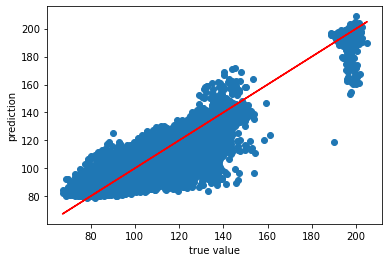

In [71]:
fit_and_eval(CatBoostRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 5.2 1JHN

Learning rate set to 0.071785
0:	learn: 10.2496757	total: 21.4ms	remaining: 21.4s
1:	learn: 9.6582769	total: 26.2ms	remaining: 13s
2:	learn: 9.1137380	total: 31.1ms	remaining: 10.3s
3:	learn: 8.6140787	total: 36.5ms	remaining: 9.08s
4:	learn: 8.1544469	total: 41.4ms	remaining: 8.24s
5:	learn: 7.7269065	total: 46.3ms	remaining: 7.68s
6:	learn: 7.3373788	total: 51.8ms	remaining: 7.35s
7:	learn: 6.9890446	total: 56.9ms	remaining: 7.05s
8:	learn: 6.6693432	total: 61.8ms	remaining: 6.8s
9:	learn: 6.3770712	total: 66.5ms	remaining: 6.58s
10:	learn: 6.1186415	total: 71.2ms	remaining: 6.4s
11:	learn: 5.8843354	total: 76ms	remaining: 6.26s
12:	learn: 5.6680903	total: 80.8ms	remaining: 6.13s
13:	learn: 5.4710220	total: 85.5ms	remaining: 6.02s
14:	learn: 5.2974355	total: 90.4ms	remaining: 5.94s
15:	learn: 5.1399493	total: 95.4ms	remaining: 5.86s
16:	learn: 5.0037943	total: 100ms	remaining: 5.8s
17:	learn: 4.8745927	total: 105ms	remaining: 5.73s
18:	learn: 4.7587509	total: 110ms	remaining: 5.7s
19

178:	learn: 3.3016247	total: 857ms	remaining: 3.93s
179:	learn: 3.2998462	total: 861ms	remaining: 3.92s
180:	learn: 3.2979441	total: 866ms	remaining: 3.92s
181:	learn: 3.2939777	total: 871ms	remaining: 3.91s
182:	learn: 3.2923098	total: 875ms	remaining: 3.91s
183:	learn: 3.2902001	total: 880ms	remaining: 3.9s
184:	learn: 3.2883364	total: 884ms	remaining: 3.9s
185:	learn: 3.2864045	total: 889ms	remaining: 3.89s
186:	learn: 3.2846881	total: 893ms	remaining: 3.88s
187:	learn: 3.2821522	total: 898ms	remaining: 3.88s
188:	learn: 3.2801525	total: 902ms	remaining: 3.87s
189:	learn: 3.2787021	total: 907ms	remaining: 3.87s
190:	learn: 3.2765156	total: 911ms	remaining: 3.86s
191:	learn: 3.2743000	total: 916ms	remaining: 3.85s
192:	learn: 3.2729102	total: 920ms	remaining: 3.85s
193:	learn: 3.2717220	total: 925ms	remaining: 3.84s
194:	learn: 3.2706441	total: 929ms	remaining: 3.83s
195:	learn: 3.2691468	total: 934ms	remaining: 3.83s
196:	learn: 3.2673772	total: 938ms	remaining: 3.82s
197:	learn: 3.

369:	learn: 3.0131732	total: 1.73s	remaining: 2.94s
370:	learn: 3.0123197	total: 1.73s	remaining: 2.93s
371:	learn: 3.0114320	total: 1.73s	remaining: 2.93s
372:	learn: 3.0098363	total: 1.74s	remaining: 2.92s
373:	learn: 3.0087822	total: 1.74s	remaining: 2.92s
374:	learn: 3.0070704	total: 1.75s	remaining: 2.91s
375:	learn: 3.0061348	total: 1.75s	remaining: 2.91s
376:	learn: 3.0052225	total: 1.76s	remaining: 2.9s
377:	learn: 3.0041962	total: 1.76s	remaining: 2.9s
378:	learn: 3.0034973	total: 1.76s	remaining: 2.89s
379:	learn: 3.0025056	total: 1.77s	remaining: 2.89s
380:	learn: 3.0014712	total: 1.77s	remaining: 2.88s
381:	learn: 3.0002462	total: 1.78s	remaining: 2.88s
382:	learn: 2.9993848	total: 1.78s	remaining: 2.87s
383:	learn: 2.9983061	total: 1.79s	remaining: 2.87s
384:	learn: 2.9972808	total: 1.79s	remaining: 2.86s
385:	learn: 2.9967526	total: 1.8s	remaining: 2.86s
386:	learn: 2.9949316	total: 1.8s	remaining: 2.85s
387:	learn: 2.9935666	total: 1.81s	remaining: 2.85s
388:	learn: 2.99

561:	learn: 2.8401448	total: 2.59s	remaining: 2.02s
562:	learn: 2.8394782	total: 2.59s	remaining: 2.01s
563:	learn: 2.8389307	total: 2.6s	remaining: 2.01s
564:	learn: 2.8382903	total: 2.6s	remaining: 2s
565:	learn: 2.8373808	total: 2.61s	remaining: 2s
566:	learn: 2.8365532	total: 2.61s	remaining: 1.99s
567:	learn: 2.8356576	total: 2.62s	remaining: 1.99s
568:	learn: 2.8347358	total: 2.62s	remaining: 1.98s
569:	learn: 2.8336104	total: 2.62s	remaining: 1.98s
570:	learn: 2.8329969	total: 2.63s	remaining: 1.98s
571:	learn: 2.8324750	total: 2.63s	remaining: 1.97s
572:	learn: 2.8315347	total: 2.64s	remaining: 1.97s
573:	learn: 2.8307215	total: 2.64s	remaining: 1.96s
574:	learn: 2.8298136	total: 2.65s	remaining: 1.96s
575:	learn: 2.8294509	total: 2.65s	remaining: 1.95s
576:	learn: 2.8285468	total: 2.66s	remaining: 1.95s
577:	learn: 2.8278073	total: 2.66s	remaining: 1.94s
578:	learn: 2.8268734	total: 2.66s	remaining: 1.94s
579:	learn: 2.8263016	total: 2.67s	remaining: 1.93s
580:	learn: 2.825261

752:	learn: 2.7053003	total: 3.46s	remaining: 1.13s
753:	learn: 2.7049967	total: 3.46s	remaining: 1.13s
754:	learn: 2.7044634	total: 3.46s	remaining: 1.12s
755:	learn: 2.7041321	total: 3.47s	remaining: 1.12s
756:	learn: 2.7035184	total: 3.47s	remaining: 1.11s
757:	learn: 2.7028562	total: 3.48s	remaining: 1.11s
758:	learn: 2.7023981	total: 3.48s	remaining: 1.11s
759:	learn: 2.7021011	total: 3.49s	remaining: 1.1s
760:	learn: 2.7011649	total: 3.49s	remaining: 1.1s
761:	learn: 2.7006126	total: 3.5s	remaining: 1.09s
762:	learn: 2.6999114	total: 3.5s	remaining: 1.09s
763:	learn: 2.6993583	total: 3.51s	remaining: 1.08s
764:	learn: 2.6987990	total: 3.51s	remaining: 1.08s
765:	learn: 2.6982228	total: 3.52s	remaining: 1.07s
766:	learn: 2.6977772	total: 3.52s	remaining: 1.07s
767:	learn: 2.6972543	total: 3.52s	remaining: 1.06s
768:	learn: 2.6964711	total: 3.53s	remaining: 1.06s
769:	learn: 2.6952508	total: 3.53s	remaining: 1.05s
770:	learn: 2.6946840	total: 3.54s	remaining: 1.05s
771:	learn: 2.69

942:	learn: 2.5959778	total: 4.32s	remaining: 261ms
943:	learn: 2.5954876	total: 4.32s	remaining: 257ms
944:	learn: 2.5952077	total: 4.33s	remaining: 252ms
945:	learn: 2.5944737	total: 4.33s	remaining: 247ms
946:	learn: 2.5942931	total: 4.34s	remaining: 243ms
947:	learn: 2.5937992	total: 4.34s	remaining: 238ms
948:	learn: 2.5932625	total: 4.35s	remaining: 234ms
949:	learn: 2.5929428	total: 4.35s	remaining: 229ms
950:	learn: 2.5922228	total: 4.36s	remaining: 224ms
951:	learn: 2.5916981	total: 4.36s	remaining: 220ms
952:	learn: 2.5911397	total: 4.37s	remaining: 215ms
953:	learn: 2.5907275	total: 4.37s	remaining: 211ms
954:	learn: 2.5902845	total: 4.37s	remaining: 206ms
955:	learn: 2.5897565	total: 4.38s	remaining: 202ms
956:	learn: 2.5893224	total: 4.38s	remaining: 197ms
957:	learn: 2.5888614	total: 4.39s	remaining: 192ms
958:	learn: 2.5883084	total: 4.39s	remaining: 188ms
959:	learn: 2.5878113	total: 4.4s	remaining: 183ms
960:	learn: 2.5871981	total: 4.4s	remaining: 179ms
961:	learn: 2.

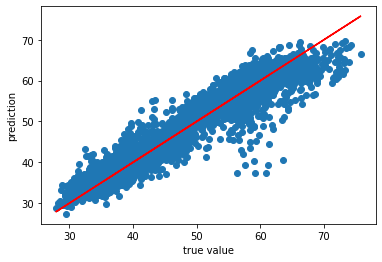

In [72]:
fit_and_eval(CatBoostRegressor(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 5.3 2JHC

Learning rate set to 0.120202
0:	learn: 4.4174809	total: 84.9ms	remaining: 1m 24s
1:	learn: 4.3301451	total: 138ms	remaining: 1m 9s
2:	learn: 4.2645657	total: 192ms	remaining: 1m 3s
3:	learn: 4.2124325	total: 252ms	remaining: 1m 2s
4:	learn: 4.1679433	total: 315ms	remaining: 1m 2s
5:	learn: 4.1329522	total: 373ms	remaining: 1m 1s
6:	learn: 4.0955545	total: 429ms	remaining: 1m
7:	learn: 4.0414153	total: 472ms	remaining: 58.5s
8:	learn: 3.9981301	total: 515ms	remaining: 56.7s
9:	learn: 3.9766036	total: 569ms	remaining: 56.3s
10:	learn: 3.9532420	total: 625ms	remaining: 56.2s
11:	learn: 3.9356335	total: 678ms	remaining: 55.8s
12:	learn: 3.9216469	total: 728ms	remaining: 55.3s
13:	learn: 3.9077930	total: 782ms	remaining: 55.1s
14:	learn: 3.8950609	total: 837ms	remaining: 55s
15:	learn: 3.8667989	total: 880ms	remaining: 54.1s
16:	learn: 3.8571868	total: 938ms	remaining: 54.2s
17:	learn: 3.8480367	total: 998ms	remaining: 54.5s
18:	learn: 3.8375082	total: 1.06s	remaining: 54.7s
19:	learn: 3.8

161:	learn: 3.5137110	total: 8.45s	remaining: 43.7s
162:	learn: 3.5129612	total: 8.5s	remaining: 43.7s
163:	learn: 3.5122202	total: 8.56s	remaining: 43.6s
164:	learn: 3.5115237	total: 8.61s	remaining: 43.6s
165:	learn: 3.5088765	total: 8.65s	remaining: 43.5s
166:	learn: 3.5079799	total: 8.71s	remaining: 43.4s
167:	learn: 3.5073438	total: 8.76s	remaining: 43.4s
168:	learn: 3.5065759	total: 8.8s	remaining: 43.3s
169:	learn: 3.5060272	total: 8.85s	remaining: 43.2s
170:	learn: 3.5050601	total: 8.9s	remaining: 43.1s
171:	learn: 3.5045419	total: 8.95s	remaining: 43.1s
172:	learn: 3.5038872	total: 8.99s	remaining: 43s
173:	learn: 3.5033126	total: 9.04s	remaining: 42.9s
174:	learn: 3.5024129	total: 9.1s	remaining: 42.9s
175:	learn: 3.5016372	total: 9.15s	remaining: 42.9s
176:	learn: 3.5010479	total: 9.21s	remaining: 42.8s
177:	learn: 3.5005949	total: 9.26s	remaining: 42.8s
178:	learn: 3.5001888	total: 9.31s	remaining: 42.7s
179:	learn: 3.4994291	total: 9.36s	remaining: 42.7s
180:	learn: 3.4988

321:	learn: 3.4288050	total: 16.7s	remaining: 35.1s
322:	learn: 3.4284607	total: 16.7s	remaining: 35s
323:	learn: 3.4280560	total: 16.8s	remaining: 35s
324:	learn: 3.4276510	total: 16.8s	remaining: 34.9s
325:	learn: 3.4272955	total: 16.9s	remaining: 34.9s
326:	learn: 3.4269624	total: 16.9s	remaining: 34.8s
327:	learn: 3.4263373	total: 17s	remaining: 34.8s
328:	learn: 3.4261092	total: 17s	remaining: 34.7s
329:	learn: 3.4257514	total: 17.1s	remaining: 34.7s
330:	learn: 3.4254672	total: 17.1s	remaining: 34.6s
331:	learn: 3.4250870	total: 17.2s	remaining: 34.6s
332:	learn: 3.4247188	total: 17.2s	remaining: 34.5s
333:	learn: 3.4243102	total: 17.3s	remaining: 34.4s
334:	learn: 3.4240707	total: 17.3s	remaining: 34.4s
335:	learn: 3.4235985	total: 17.4s	remaining: 34.4s
336:	learn: 3.4231459	total: 17.4s	remaining: 34.3s
337:	learn: 3.4228583	total: 17.5s	remaining: 34.3s
338:	learn: 3.4224319	total: 17.5s	remaining: 34.2s
339:	learn: 3.4220979	total: 17.6s	remaining: 34.1s
340:	learn: 3.421843

481:	learn: 3.3795408	total: 24.9s	remaining: 26.7s
482:	learn: 3.3792772	total: 24.9s	remaining: 26.7s
483:	learn: 3.3789792	total: 25s	remaining: 26.6s
484:	learn: 3.3788086	total: 25s	remaining: 26.6s
485:	learn: 3.3784777	total: 25.1s	remaining: 26.5s
486:	learn: 3.3782857	total: 25.1s	remaining: 26.5s
487:	learn: 3.3780384	total: 25.2s	remaining: 26.4s
488:	learn: 3.3778227	total: 25.2s	remaining: 26.4s
489:	learn: 3.3776611	total: 25.3s	remaining: 26.3s
490:	learn: 3.3773378	total: 25.3s	remaining: 26.3s
491:	learn: 3.3769790	total: 25.4s	remaining: 26.2s
492:	learn: 3.3766032	total: 25.4s	remaining: 26.1s
493:	learn: 3.3762210	total: 25.5s	remaining: 26.1s
494:	learn: 3.3758524	total: 25.5s	remaining: 26.1s
495:	learn: 3.3754761	total: 25.6s	remaining: 26s
496:	learn: 3.3752369	total: 25.6s	remaining: 26s
497:	learn: 3.3749826	total: 25.7s	remaining: 25.9s
498:	learn: 3.3746737	total: 25.7s	remaining: 25.9s
499:	learn: 3.3744149	total: 25.8s	remaining: 25.8s
500:	learn: 3.374175

640:	learn: 3.3407059	total: 33s	remaining: 18.5s
641:	learn: 3.3405103	total: 33s	remaining: 18.4s
642:	learn: 3.3401574	total: 33.1s	remaining: 18.4s
643:	learn: 3.3399539	total: 33.1s	remaining: 18.3s
644:	learn: 3.3396574	total: 33.2s	remaining: 18.3s
645:	learn: 3.3393287	total: 33.2s	remaining: 18.2s
646:	learn: 3.3392433	total: 33.3s	remaining: 18.2s
647:	learn: 3.3390691	total: 33.3s	remaining: 18.1s
648:	learn: 3.3388712	total: 33.4s	remaining: 18s
649:	learn: 3.3386668	total: 33.4s	remaining: 18s
650:	learn: 3.3384408	total: 33.5s	remaining: 17.9s
651:	learn: 3.3380473	total: 33.5s	remaining: 17.9s
652:	learn: 3.3378557	total: 33.6s	remaining: 17.8s
653:	learn: 3.3375606	total: 33.6s	remaining: 17.8s
654:	learn: 3.3374041	total: 33.7s	remaining: 17.7s
655:	learn: 3.3370956	total: 33.7s	remaining: 17.7s
656:	learn: 3.3368996	total: 33.8s	remaining: 17.6s
657:	learn: 3.3367136	total: 33.8s	remaining: 17.6s
658:	learn: 3.3364784	total: 33.9s	remaining: 17.5s
659:	learn: 3.336301

802:	learn: 3.3083830	total: 41.2s	remaining: 10.1s
803:	learn: 3.3082058	total: 41.3s	remaining: 10.1s
804:	learn: 3.3079607	total: 41.3s	remaining: 10s
805:	learn: 3.3077549	total: 41.4s	remaining: 9.95s
806:	learn: 3.3076127	total: 41.4s	remaining: 9.9s
807:	learn: 3.3074574	total: 41.5s	remaining: 9.85s
808:	learn: 3.3073038	total: 41.5s	remaining: 9.8s
809:	learn: 3.3071055	total: 41.6s	remaining: 9.75s
810:	learn: 3.3069256	total: 41.6s	remaining: 9.7s
811:	learn: 3.3067115	total: 41.7s	remaining: 9.65s
812:	learn: 3.3065549	total: 41.7s	remaining: 9.6s
813:	learn: 3.3062809	total: 41.8s	remaining: 9.55s
814:	learn: 3.3060842	total: 41.8s	remaining: 9.49s
815:	learn: 3.3059020	total: 41.9s	remaining: 9.44s
816:	learn: 3.3056700	total: 41.9s	remaining: 9.39s
817:	learn: 3.3054409	total: 42s	remaining: 9.34s
818:	learn: 3.3053487	total: 42s	remaining: 9.29s
819:	learn: 3.3052055	total: 42.1s	remaining: 9.24s
820:	learn: 3.3048130	total: 42.1s	remaining: 9.19s
821:	learn: 3.3045445	

963:	learn: 3.2813182	total: 49.4s	remaining: 1.84s
964:	learn: 3.2811138	total: 49.5s	remaining: 1.79s
965:	learn: 3.2809323	total: 49.5s	remaining: 1.74s
966:	learn: 3.2806940	total: 49.6s	remaining: 1.69s
967:	learn: 3.2806161	total: 49.6s	remaining: 1.64s
968:	learn: 3.2804835	total: 49.7s	remaining: 1.59s
969:	learn: 3.2803747	total: 49.7s	remaining: 1.54s
970:	learn: 3.2801997	total: 49.8s	remaining: 1.49s
971:	learn: 3.2800641	total: 49.8s	remaining: 1.44s
972:	learn: 3.2799307	total: 49.9s	remaining: 1.38s
973:	learn: 3.2797898	total: 49.9s	remaining: 1.33s
974:	learn: 3.2796567	total: 50s	remaining: 1.28s
975:	learn: 3.2795244	total: 50s	remaining: 1.23s
976:	learn: 3.2794206	total: 50.1s	remaining: 1.18s
977:	learn: 3.2792743	total: 50.1s	remaining: 1.13s
978:	learn: 3.2790755	total: 50.2s	remaining: 1.08s
979:	learn: 3.2789480	total: 50.2s	remaining: 1.02s
980:	learn: 3.2788593	total: 50.3s	remaining: 974ms
981:	learn: 3.2786787	total: 50.3s	remaining: 923ms
982:	learn: 3.27

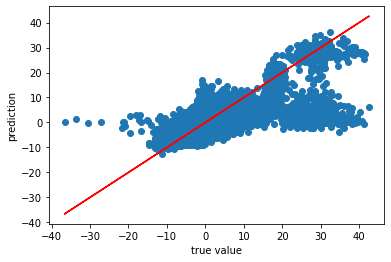

In [73]:
fit_and_eval(CatBoostRegressor(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 5.4 2JHH

Learning rate set to 0.100951
0:	learn: 3.7159065	total: 52.4ms	remaining: 52.3s
1:	learn: 3.4911477	total: 72.6ms	remaining: 36.2s
2:	learn: 3.2942264	total: 92.9ms	remaining: 30.9s
3:	learn: 3.1277280	total: 113ms	remaining: 28.2s
4:	learn: 2.9817049	total: 134ms	remaining: 26.6s
5:	learn: 2.8559256	total: 155ms	remaining: 25.7s
6:	learn: 2.7470391	total: 175ms	remaining: 24.8s
7:	learn: 2.6537704	total: 196ms	remaining: 24.3s
8:	learn: 2.5741031	total: 216ms	remaining: 23.7s
9:	learn: 2.5088460	total: 236ms	remaining: 23.4s
10:	learn: 2.4520392	total: 256ms	remaining: 23s
11:	learn: 2.4028191	total: 275ms	remaining: 22.7s
12:	learn: 2.3621903	total: 295ms	remaining: 22.4s
13:	learn: 2.3284491	total: 315ms	remaining: 22.2s
14:	learn: 2.2993574	total: 338ms	remaining: 22.2s
15:	learn: 2.2753356	total: 357ms	remaining: 22s
16:	learn: 2.2548980	total: 377ms	remaining: 21.8s
17:	learn: 2.2375468	total: 396ms	remaining: 21.6s
18:	learn: 2.2228777	total: 418ms	remaining: 21.6s
19:	learn: 2

162:	learn: 1.8474127	total: 3.14s	remaining: 16.1s
163:	learn: 1.8464134	total: 3.15s	remaining: 16.1s
164:	learn: 1.8458248	total: 3.17s	remaining: 16.1s
165:	learn: 1.8450782	total: 3.19s	remaining: 16s
166:	learn: 1.8445571	total: 3.21s	remaining: 16s
167:	learn: 1.8440196	total: 3.23s	remaining: 16s
168:	learn: 1.8431387	total: 3.25s	remaining: 16s
169:	learn: 1.8425761	total: 3.26s	remaining: 15.9s
170:	learn: 1.8416355	total: 3.28s	remaining: 15.9s
171:	learn: 1.8410534	total: 3.3s	remaining: 15.9s
172:	learn: 1.8397417	total: 3.32s	remaining: 15.9s
173:	learn: 1.8385044	total: 3.34s	remaining: 15.9s
174:	learn: 1.8377153	total: 3.36s	remaining: 15.8s
175:	learn: 1.8372881	total: 3.38s	remaining: 15.8s
176:	learn: 1.8363300	total: 3.39s	remaining: 15.8s
177:	learn: 1.8353833	total: 3.41s	remaining: 15.7s
178:	learn: 1.8348288	total: 3.43s	remaining: 15.7s
179:	learn: 1.8337444	total: 3.44s	remaining: 15.7s
180:	learn: 1.8327806	total: 3.46s	remaining: 15.7s
181:	learn: 1.8323503

326:	learn: 1.7548537	total: 6.17s	remaining: 12.7s
327:	learn: 1.7541504	total: 6.19s	remaining: 12.7s
328:	learn: 1.7536665	total: 6.21s	remaining: 12.7s
329:	learn: 1.7528994	total: 6.23s	remaining: 12.6s
330:	learn: 1.7521734	total: 6.25s	remaining: 12.6s
331:	learn: 1.7519150	total: 6.27s	remaining: 12.6s
332:	learn: 1.7515890	total: 6.29s	remaining: 12.6s
333:	learn: 1.7511191	total: 6.31s	remaining: 12.6s
334:	learn: 1.7507960	total: 6.33s	remaining: 12.6s
335:	learn: 1.7505160	total: 6.35s	remaining: 12.5s
336:	learn: 1.7492691	total: 6.37s	remaining: 12.5s
337:	learn: 1.7487552	total: 6.38s	remaining: 12.5s
338:	learn: 1.7483467	total: 6.41s	remaining: 12.5s
339:	learn: 1.7480613	total: 6.42s	remaining: 12.5s
340:	learn: 1.7474097	total: 6.44s	remaining: 12.5s
341:	learn: 1.7469251	total: 6.46s	remaining: 12.4s
342:	learn: 1.7466177	total: 6.48s	remaining: 12.4s
343:	learn: 1.7461589	total: 6.5s	remaining: 12.4s
344:	learn: 1.7459216	total: 6.51s	remaining: 12.4s
345:	learn: 1

494:	learn: 1.6978179	total: 9.35s	remaining: 9.53s
495:	learn: 1.6975536	total: 9.36s	remaining: 9.51s
496:	learn: 1.6972527	total: 9.38s	remaining: 9.49s
497:	learn: 1.6970588	total: 9.4s	remaining: 9.47s
498:	learn: 1.6957963	total: 9.42s	remaining: 9.45s
499:	learn: 1.6952722	total: 9.43s	remaining: 9.43s
500:	learn: 1.6948747	total: 9.45s	remaining: 9.41s
501:	learn: 1.6946932	total: 9.47s	remaining: 9.39s
502:	learn: 1.6944400	total: 9.49s	remaining: 9.37s
503:	learn: 1.6942459	total: 9.51s	remaining: 9.36s
504:	learn: 1.6940474	total: 9.53s	remaining: 9.34s
505:	learn: 1.6937854	total: 9.54s	remaining: 9.32s
506:	learn: 1.6935321	total: 9.56s	remaining: 9.3s
507:	learn: 1.6931889	total: 9.58s	remaining: 9.28s
508:	learn: 1.6928266	total: 9.6s	remaining: 9.26s
509:	learn: 1.6926438	total: 9.62s	remaining: 9.24s
510:	learn: 1.6922730	total: 9.63s	remaining: 9.22s
511:	learn: 1.6921313	total: 9.65s	remaining: 9.2s
512:	learn: 1.6918952	total: 9.67s	remaining: 9.18s
513:	learn: 1.69

653:	learn: 1.6565961	total: 12.3s	remaining: 6.52s
654:	learn: 1.6562609	total: 12.3s	remaining: 6.5s
655:	learn: 1.6560338	total: 12.4s	remaining: 6.48s
656:	learn: 1.6558578	total: 12.4s	remaining: 6.46s
657:	learn: 1.6555488	total: 12.4s	remaining: 6.44s
658:	learn: 1.6554043	total: 12.4s	remaining: 6.42s
659:	learn: 1.6551816	total: 12.4s	remaining: 6.4s
660:	learn: 1.6548803	total: 12.4s	remaining: 6.38s
661:	learn: 1.6547522	total: 12.5s	remaining: 6.37s
662:	learn: 1.6545460	total: 12.5s	remaining: 6.35s
663:	learn: 1.6544044	total: 12.5s	remaining: 6.33s
664:	learn: 1.6541731	total: 12.5s	remaining: 6.31s
665:	learn: 1.6540633	total: 12.5s	remaining: 6.29s
666:	learn: 1.6537717	total: 12.6s	remaining: 6.27s
667:	learn: 1.6536673	total: 12.6s	remaining: 6.25s
668:	learn: 1.6534701	total: 12.6s	remaining: 6.24s
669:	learn: 1.6533492	total: 12.6s	remaining: 6.21s
670:	learn: 1.6529797	total: 12.6s	remaining: 6.2s
671:	learn: 1.6528265	total: 12.7s	remaining: 6.18s
672:	learn: 1.6

815:	learn: 1.6251806	total: 15.3s	remaining: 3.46s
816:	learn: 1.6250244	total: 15.4s	remaining: 3.44s
817:	learn: 1.6249106	total: 15.4s	remaining: 3.42s
818:	learn: 1.6247385	total: 15.4s	remaining: 3.4s
819:	learn: 1.6245282	total: 15.4s	remaining: 3.38s
820:	learn: 1.6243809	total: 15.4s	remaining: 3.36s
821:	learn: 1.6241935	total: 15.4s	remaining: 3.35s
822:	learn: 1.6240573	total: 15.5s	remaining: 3.33s
823:	learn: 1.6238760	total: 15.5s	remaining: 3.31s
824:	learn: 1.6236765	total: 15.5s	remaining: 3.29s
825:	learn: 1.6235608	total: 15.5s	remaining: 3.27s
826:	learn: 1.6232736	total: 15.5s	remaining: 3.25s
827:	learn: 1.6231259	total: 15.6s	remaining: 3.23s
828:	learn: 1.6229071	total: 15.6s	remaining: 3.21s
829:	learn: 1.6225975	total: 15.6s	remaining: 3.19s
830:	learn: 1.6223762	total: 15.6s	remaining: 3.17s
831:	learn: 1.6221235	total: 15.6s	remaining: 3.16s
832:	learn: 1.6219616	total: 15.6s	remaining: 3.14s
833:	learn: 1.6218534	total: 15.7s	remaining: 3.12s
834:	learn: 1

975:	learn: 1.5989412	total: 18.3s	remaining: 451ms
976:	learn: 1.5988538	total: 18.3s	remaining: 432ms
977:	learn: 1.5987237	total: 18.4s	remaining: 413ms
978:	learn: 1.5986115	total: 18.4s	remaining: 394ms
979:	learn: 1.5983941	total: 18.4s	remaining: 376ms
980:	learn: 1.5983090	total: 18.4s	remaining: 357ms
981:	learn: 1.5981447	total: 18.4s	remaining: 338ms
982:	learn: 1.5979924	total: 18.5s	remaining: 319ms
983:	learn: 1.5978492	total: 18.5s	remaining: 301ms
984:	learn: 1.5977036	total: 18.5s	remaining: 282ms
985:	learn: 1.5975758	total: 18.5s	remaining: 263ms
986:	learn: 1.5975107	total: 18.5s	remaining: 244ms
987:	learn: 1.5974097	total: 18.6s	remaining: 225ms
988:	learn: 1.5973160	total: 18.6s	remaining: 207ms
989:	learn: 1.5971509	total: 18.6s	remaining: 188ms
990:	learn: 1.5970042	total: 18.6s	remaining: 169ms
991:	learn: 1.5968231	total: 18.6s	remaining: 150ms
992:	learn: 1.5966251	total: 18.6s	remaining: 131ms
993:	learn: 1.5964670	total: 18.7s	remaining: 113ms
994:	learn: 

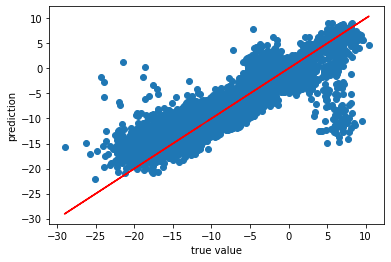

In [74]:
fit_and_eval(CatBoostRegressor(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 5.5 2JHN

Learning rate set to 0.084108
0:	learn: 3.5991381	total: 8.53ms	remaining: 8.53s
1:	learn: 3.5286038	total: 16.3ms	remaining: 8.13s
2:	learn: 3.4677894	total: 24.2ms	remaining: 8.04s
3:	learn: 3.4134431	total: 31.9ms	remaining: 7.94s
4:	learn: 3.3633943	total: 39.9ms	remaining: 7.94s
5:	learn: 3.3222259	total: 47.6ms	remaining: 7.88s
6:	learn: 3.2836980	total: 55.1ms	remaining: 7.81s
7:	learn: 3.2484415	total: 62.3ms	remaining: 7.72s
8:	learn: 3.2201011	total: 69.7ms	remaining: 7.67s
9:	learn: 3.1906664	total: 76.9ms	remaining: 7.62s
10:	learn: 3.1680215	total: 84.7ms	remaining: 7.61s
11:	learn: 3.1441542	total: 92.7ms	remaining: 7.63s
12:	learn: 3.1221931	total: 99.7ms	remaining: 7.57s
13:	learn: 3.1033373	total: 107ms	remaining: 7.53s
14:	learn: 3.0831806	total: 114ms	remaining: 7.5s
15:	learn: 3.0654964	total: 122ms	remaining: 7.47s
16:	learn: 3.0486089	total: 129ms	remaining: 7.46s
17:	learn: 3.0347291	total: 137ms	remaining: 7.45s
18:	learn: 3.0221091	total: 145ms	remaining: 7.47s

179:	learn: 2.5223933	total: 1.4s	remaining: 6.37s
180:	learn: 2.5208815	total: 1.41s	remaining: 6.36s
181:	learn: 2.5193797	total: 1.41s	remaining: 6.35s
182:	learn: 2.5182110	total: 1.42s	remaining: 6.34s
183:	learn: 2.5168311	total: 1.43s	remaining: 6.33s
184:	learn: 2.5156887	total: 1.44s	remaining: 6.33s
185:	learn: 2.5138829	total: 1.44s	remaining: 6.31s
186:	learn: 2.5118217	total: 1.45s	remaining: 6.3s
187:	learn: 2.5093553	total: 1.46s	remaining: 6.29s
188:	learn: 2.5084862	total: 1.46s	remaining: 6.28s
189:	learn: 2.5071859	total: 1.47s	remaining: 6.28s
190:	learn: 2.5062882	total: 1.48s	remaining: 6.26s
191:	learn: 2.5055534	total: 1.49s	remaining: 6.26s
192:	learn: 2.5039561	total: 1.49s	remaining: 6.25s
193:	learn: 2.5029760	total: 1.5s	remaining: 6.24s
194:	learn: 2.5017221	total: 1.51s	remaining: 6.23s
195:	learn: 2.5005444	total: 1.51s	remaining: 6.22s
196:	learn: 2.4996049	total: 1.52s	remaining: 6.21s
197:	learn: 2.4983977	total: 1.53s	remaining: 6.2s
198:	learn: 2.49

339:	learn: 2.3695250	total: 2.64s	remaining: 5.12s
340:	learn: 2.3689364	total: 2.65s	remaining: 5.12s
341:	learn: 2.3682484	total: 2.65s	remaining: 5.11s
342:	learn: 2.3674016	total: 2.66s	remaining: 5.1s
343:	learn: 2.3664407	total: 2.67s	remaining: 5.09s
344:	learn: 2.3658918	total: 2.68s	remaining: 5.09s
345:	learn: 2.3649235	total: 2.69s	remaining: 5.08s
346:	learn: 2.3643941	total: 2.69s	remaining: 5.07s
347:	learn: 2.3637757	total: 2.7s	remaining: 5.06s
348:	learn: 2.3631026	total: 2.71s	remaining: 5.06s
349:	learn: 2.3624925	total: 2.72s	remaining: 5.05s
350:	learn: 2.3617015	total: 2.73s	remaining: 5.04s
351:	learn: 2.3609500	total: 2.73s	remaining: 5.03s
352:	learn: 2.3601467	total: 2.74s	remaining: 5.02s
353:	learn: 2.3593911	total: 2.75s	remaining: 5.02s
354:	learn: 2.3587539	total: 2.76s	remaining: 5.01s
355:	learn: 2.3578215	total: 2.77s	remaining: 5s
356:	learn: 2.3569950	total: 2.77s	remaining: 5s
357:	learn: 2.3561390	total: 2.78s	remaining: 4.99s
358:	learn: 2.355252

498:	learn: 2.2742463	total: 3.88s	remaining: 3.89s
499:	learn: 2.2734338	total: 3.88s	remaining: 3.88s
500:	learn: 2.2728981	total: 3.89s	remaining: 3.88s
501:	learn: 2.2723771	total: 3.9s	remaining: 3.87s
502:	learn: 2.2717148	total: 3.91s	remaining: 3.86s
503:	learn: 2.2711632	total: 3.91s	remaining: 3.85s
504:	learn: 2.2705990	total: 3.92s	remaining: 3.84s
505:	learn: 2.2700609	total: 3.93s	remaining: 3.83s
506:	learn: 2.2696030	total: 3.94s	remaining: 3.83s
507:	learn: 2.2691579	total: 3.94s	remaining: 3.82s
508:	learn: 2.2684753	total: 3.95s	remaining: 3.81s
509:	learn: 2.2680111	total: 3.96s	remaining: 3.8s
510:	learn: 2.2674862	total: 3.96s	remaining: 3.79s
511:	learn: 2.2668781	total: 3.97s	remaining: 3.79s
512:	learn: 2.2663682	total: 3.98s	remaining: 3.78s
513:	learn: 2.2658974	total: 3.99s	remaining: 3.77s
514:	learn: 2.2651814	total: 4s	remaining: 3.76s
515:	learn: 2.2647494	total: 4s	remaining: 3.75s
516:	learn: 2.2642488	total: 4.01s	remaining: 3.75s
517:	learn: 2.263710

660:	learn: 2.2001553	total: 5.12s	remaining: 2.62s
661:	learn: 2.1998690	total: 5.13s	remaining: 2.62s
662:	learn: 2.1995208	total: 5.13s	remaining: 2.61s
663:	learn: 2.1991966	total: 5.14s	remaining: 2.6s
664:	learn: 2.1988008	total: 5.15s	remaining: 2.59s
665:	learn: 2.1983954	total: 5.16s	remaining: 2.58s
666:	learn: 2.1980147	total: 5.16s	remaining: 2.58s
667:	learn: 2.1974261	total: 5.17s	remaining: 2.57s
668:	learn: 2.1967129	total: 5.18s	remaining: 2.56s
669:	learn: 2.1962967	total: 5.19s	remaining: 2.55s
670:	learn: 2.1957739	total: 5.2s	remaining: 2.55s
671:	learn: 2.1953615	total: 5.2s	remaining: 2.54s
672:	learn: 2.1949648	total: 5.21s	remaining: 2.53s
673:	learn: 2.1945865	total: 5.22s	remaining: 2.52s
674:	learn: 2.1940540	total: 5.22s	remaining: 2.52s
675:	learn: 2.1936371	total: 5.23s	remaining: 2.51s
676:	learn: 2.1932607	total: 5.24s	remaining: 2.5s
677:	learn: 2.1929100	total: 5.25s	remaining: 2.49s
678:	learn: 2.1924803	total: 5.25s	remaining: 2.48s
679:	learn: 2.19

821:	learn: 2.1393351	total: 6.36s	remaining: 1.38s
822:	learn: 2.1389955	total: 6.37s	remaining: 1.37s
823:	learn: 2.1386583	total: 6.37s	remaining: 1.36s
824:	learn: 2.1384097	total: 6.38s	remaining: 1.35s
825:	learn: 2.1383165	total: 6.39s	remaining: 1.34s
826:	learn: 2.1380923	total: 6.39s	remaining: 1.34s
827:	learn: 2.1378348	total: 6.4s	remaining: 1.33s
828:	learn: 2.1373532	total: 6.41s	remaining: 1.32s
829:	learn: 2.1370311	total: 6.42s	remaining: 1.31s
830:	learn: 2.1367305	total: 6.43s	remaining: 1.31s
831:	learn: 2.1362544	total: 6.43s	remaining: 1.3s
832:	learn: 2.1360073	total: 6.44s	remaining: 1.29s
833:	learn: 2.1354831	total: 6.45s	remaining: 1.28s
834:	learn: 2.1352814	total: 6.46s	remaining: 1.27s
835:	learn: 2.1349597	total: 6.46s	remaining: 1.27s
836:	learn: 2.1347279	total: 6.47s	remaining: 1.26s
837:	learn: 2.1344568	total: 6.48s	remaining: 1.25s
838:	learn: 2.1341370	total: 6.49s	remaining: 1.24s
839:	learn: 2.1337329	total: 6.49s	remaining: 1.24s
840:	learn: 2.

Result Report

Train R2 Score: 0.6784371771739331
Validation R2 Score: 0.6238165676790478

Train RMSE: 2.086105616769079
Validation RMSE: 2.2496482876040194

Train MAE: 1.5002818925423442
Validation MAE: 1.6021484206906915


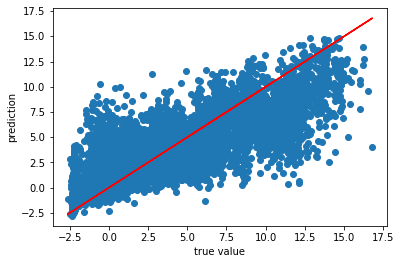

In [75]:
fit_and_eval(CatBoostRegressor(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 5.6 3JHC

Learning rate set to 0.125661
0:	learn: 2.9905965	total: 89.5ms	remaining: 1m 29s
1:	learn: 2.9255925	total: 160ms	remaining: 1m 19s
2:	learn: 2.8685349	total: 234ms	remaining: 1m 17s
3:	learn: 2.8248775	total: 313ms	remaining: 1m 17s
4:	learn: 2.7905016	total: 391ms	remaining: 1m 17s
5:	learn: 2.7622010	total: 467ms	remaining: 1m 17s
6:	learn: 2.7380930	total: 539ms	remaining: 1m 16s
7:	learn: 2.7181675	total: 612ms	remaining: 1m 15s
8:	learn: 2.7010644	total: 682ms	remaining: 1m 15s
9:	learn: 2.6870191	total: 755ms	remaining: 1m 14s
10:	learn: 2.6738211	total: 822ms	remaining: 1m 13s
11:	learn: 2.6640920	total: 902ms	remaining: 1m 14s
12:	learn: 2.6554553	total: 972ms	remaining: 1m 13s
13:	learn: 2.6463932	total: 1.03s	remaining: 1m 12s
14:	learn: 2.6388924	total: 1.11s	remaining: 1m 12s
15:	learn: 2.6325952	total: 1.19s	remaining: 1m 13s
16:	learn: 2.6273091	total: 1.26s	remaining: 1m 13s
17:	learn: 2.6213893	total: 1.34s	remaining: 1m 12s
18:	learn: 2.6171319	total: 1.41s	remaining

162:	learn: 2.4393898	total: 11.2s	remaining: 57.6s
163:	learn: 2.4389788	total: 11.3s	remaining: 57.5s
164:	learn: 2.4385285	total: 11.4s	remaining: 57.5s
165:	learn: 2.4381061	total: 11.4s	remaining: 57.4s
166:	learn: 2.4375578	total: 11.5s	remaining: 57.3s
167:	learn: 2.4368302	total: 11.6s	remaining: 57.2s
168:	learn: 2.4360123	total: 11.6s	remaining: 57.2s
169:	learn: 2.4354600	total: 11.7s	remaining: 57.1s
170:	learn: 2.4351552	total: 11.8s	remaining: 57s
171:	learn: 2.4347293	total: 11.8s	remaining: 57s
172:	learn: 2.4344010	total: 11.9s	remaining: 56.9s
173:	learn: 2.4339309	total: 12s	remaining: 56.8s
174:	learn: 2.4332746	total: 12s	remaining: 56.7s
175:	learn: 2.4328411	total: 12.1s	remaining: 56.6s
176:	learn: 2.4322658	total: 12.2s	remaining: 56.5s
177:	learn: 2.4320566	total: 12.2s	remaining: 56.4s
178:	learn: 2.4315848	total: 12.3s	remaining: 56.3s
179:	learn: 2.4311462	total: 12.3s	remaining: 56.3s
180:	learn: 2.4307869	total: 12.4s	remaining: 56.2s
181:	learn: 2.430416

323:	learn: 2.3739805	total: 22.2s	remaining: 46.2s
324:	learn: 2.3734547	total: 22.2s	remaining: 46.2s
325:	learn: 2.3730798	total: 22.3s	remaining: 46.1s
326:	learn: 2.3726417	total: 22.4s	remaining: 46.1s
327:	learn: 2.3724167	total: 22.5s	remaining: 46s
328:	learn: 2.3721000	total: 22.5s	remaining: 45.9s
329:	learn: 2.3717697	total: 22.6s	remaining: 45.9s
330:	learn: 2.3711707	total: 22.7s	remaining: 45.8s
331:	learn: 2.3708420	total: 22.7s	remaining: 45.8s
332:	learn: 2.3706148	total: 22.8s	remaining: 45.7s
333:	learn: 2.3702736	total: 22.9s	remaining: 45.6s
334:	learn: 2.3701607	total: 23s	remaining: 45.6s
335:	learn: 2.3699508	total: 23s	remaining: 45.5s
336:	learn: 2.3696020	total: 23.1s	remaining: 45.4s
337:	learn: 2.3692661	total: 23.2s	remaining: 45.4s
338:	learn: 2.3689263	total: 23.2s	remaining: 45.3s
339:	learn: 2.3685593	total: 23.3s	remaining: 45.2s
340:	learn: 2.3683500	total: 23.4s	remaining: 45.2s
341:	learn: 2.3681017	total: 23.4s	remaining: 45.1s
342:	learn: 2.3678

483:	learn: 2.3304302	total: 32.9s	remaining: 35.1s
484:	learn: 2.3302103	total: 33s	remaining: 35s
485:	learn: 2.3300765	total: 33.1s	remaining: 35s
486:	learn: 2.3299213	total: 33.1s	remaining: 34.9s
487:	learn: 2.3297508	total: 33.2s	remaining: 34.8s
488:	learn: 2.3295753	total: 33.3s	remaining: 34.8s
489:	learn: 2.3294212	total: 33.3s	remaining: 34.7s
490:	learn: 2.3291043	total: 33.4s	remaining: 34.6s
491:	learn: 2.3288575	total: 33.5s	remaining: 34.6s
492:	learn: 2.3285708	total: 33.5s	remaining: 34.5s
493:	learn: 2.3282672	total: 33.6s	remaining: 34.4s
494:	learn: 2.3280682	total: 33.7s	remaining: 34.4s
495:	learn: 2.3276821	total: 33.8s	remaining: 34.3s
496:	learn: 2.3274520	total: 33.8s	remaining: 34.2s
497:	learn: 2.3272400	total: 33.9s	remaining: 34.2s
498:	learn: 2.3270734	total: 33.9s	remaining: 34.1s
499:	learn: 2.3268430	total: 34s	remaining: 34s
500:	learn: 2.3266011	total: 34.1s	remaining: 33.9s
501:	learn: 2.3264707	total: 34.1s	remaining: 33.9s
502:	learn: 2.3262354	

643:	learn: 2.2979359	total: 43.5s	remaining: 24s
644:	learn: 2.2977314	total: 43.5s	remaining: 24s
645:	learn: 2.2976053	total: 43.6s	remaining: 23.9s
646:	learn: 2.2974455	total: 43.7s	remaining: 23.8s
647:	learn: 2.2972987	total: 43.7s	remaining: 23.8s
648:	learn: 2.2971405	total: 43.8s	remaining: 23.7s
649:	learn: 2.2968872	total: 43.9s	remaining: 23.6s
650:	learn: 2.2967433	total: 43.9s	remaining: 23.6s
651:	learn: 2.2966275	total: 44s	remaining: 23.5s
652:	learn: 2.2964147	total: 44.1s	remaining: 23.4s
653:	learn: 2.2962173	total: 44.1s	remaining: 23.3s
654:	learn: 2.2960661	total: 44.2s	remaining: 23.3s
655:	learn: 2.2958827	total: 44.3s	remaining: 23.2s
656:	learn: 2.2957635	total: 44.3s	remaining: 23.1s
657:	learn: 2.2956008	total: 44.4s	remaining: 23.1s
658:	learn: 2.2954872	total: 44.5s	remaining: 23s
659:	learn: 2.2952352	total: 44.5s	remaining: 22.9s
660:	learn: 2.2950646	total: 44.6s	remaining: 22.9s
661:	learn: 2.2948816	total: 44.7s	remaining: 22.8s
662:	learn: 2.294739

804:	learn: 2.2720975	total: 54s	remaining: 13.1s
805:	learn: 2.2719813	total: 54.1s	remaining: 13s
806:	learn: 2.2717537	total: 54.2s	remaining: 13s
807:	learn: 2.2716476	total: 54.2s	remaining: 12.9s
808:	learn: 2.2713635	total: 54.3s	remaining: 12.8s
809:	learn: 2.2712799	total: 54.4s	remaining: 12.7s
810:	learn: 2.2711807	total: 54.4s	remaining: 12.7s
811:	learn: 2.2710488	total: 54.5s	remaining: 12.6s
812:	learn: 2.2709167	total: 54.5s	remaining: 12.5s
813:	learn: 2.2707795	total: 54.6s	remaining: 12.5s
814:	learn: 2.2705971	total: 54.7s	remaining: 12.4s
815:	learn: 2.2704598	total: 54.8s	remaining: 12.3s
816:	learn: 2.2702982	total: 54.8s	remaining: 12.3s
817:	learn: 2.2701884	total: 54.9s	remaining: 12.2s
818:	learn: 2.2700756	total: 55s	remaining: 12.1s
819:	learn: 2.2699642	total: 55s	remaining: 12.1s
820:	learn: 2.2698859	total: 55.1s	remaining: 12s
821:	learn: 2.2697188	total: 55.2s	remaining: 11.9s
822:	learn: 2.2694855	total: 55.2s	remaining: 11.9s
823:	learn: 2.2692538	to

966:	learn: 2.2492258	total: 1m 4s	remaining: 2.21s
967:	learn: 2.2491545	total: 1m 4s	remaining: 2.14s
968:	learn: 2.2490296	total: 1m 4s	remaining: 2.07s
969:	learn: 2.2488875	total: 1m 4s	remaining: 2s
970:	learn: 2.2487256	total: 1m 4s	remaining: 1.94s
971:	learn: 2.2485537	total: 1m 4s	remaining: 1.87s
972:	learn: 2.2484191	total: 1m 5s	remaining: 1.8s
973:	learn: 2.2482562	total: 1m 5s	remaining: 1.74s
974:	learn: 2.2481395	total: 1m 5s	remaining: 1.67s
975:	learn: 2.2479823	total: 1m 5s	remaining: 1.6s
976:	learn: 2.2478645	total: 1m 5s	remaining: 1.54s
977:	learn: 2.2476918	total: 1m 5s	remaining: 1.47s
978:	learn: 2.2475655	total: 1m 5s	remaining: 1.4s
979:	learn: 2.2474714	total: 1m 5s	remaining: 1.34s
980:	learn: 2.2473005	total: 1m 5s	remaining: 1.27s
981:	learn: 2.2472203	total: 1m 5s	remaining: 1.2s
982:	learn: 2.2471173	total: 1m 5s	remaining: 1.14s
983:	learn: 2.2469665	total: 1m 5s	remaining: 1.07s
984:	learn: 2.2468734	total: 1m 5s	remaining: 1s
985:	learn: 2.2466314	

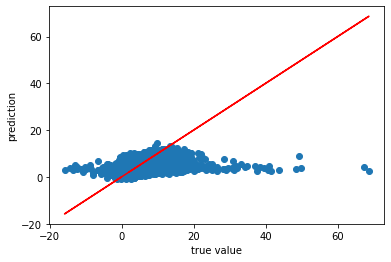

In [76]:
fit_and_eval(CatBoostRegressor(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 5.7 3JHH

Learning rate set to 0.108324
0:	learn: 3.5229798	total: 64.6ms	remaining: 1m 4s
1:	learn: 3.3678999	total: 95ms	remaining: 47.4s
2:	learn: 3.2254059	total: 126ms	remaining: 41.8s
3:	learn: 3.0990601	total: 157ms	remaining: 39.1s
4:	learn: 3.0020107	total: 187ms	remaining: 37.2s
5:	learn: 2.9193895	total: 217ms	remaining: 35.9s
6:	learn: 2.8471735	total: 248ms	remaining: 35.1s
7:	learn: 2.7872933	total: 281ms	remaining: 34.9s
8:	learn: 2.7392616	total: 311ms	remaining: 34.3s
9:	learn: 2.6832316	total: 343ms	remaining: 33.9s
10:	learn: 2.6395528	total: 374ms	remaining: 33.6s
11:	learn: 2.5957145	total: 405ms	remaining: 33.4s
12:	learn: 2.5697865	total: 436ms	remaining: 33.1s
13:	learn: 2.5446588	total: 468ms	remaining: 32.9s
14:	learn: 2.5138997	total: 499ms	remaining: 32.8s
15:	learn: 2.4928113	total: 530ms	remaining: 32.6s
16:	learn: 2.4689011	total: 561ms	remaining: 32.4s
17:	learn: 2.4556017	total: 590ms	remaining: 32.2s
18:	learn: 2.4449930	total: 620ms	remaining: 32s
19:	learn: 2.

165:	learn: 2.0854193	total: 4.69s	remaining: 23.5s
166:	learn: 2.0846067	total: 4.71s	remaining: 23.5s
167:	learn: 2.0837898	total: 4.74s	remaining: 23.5s
168:	learn: 2.0826804	total: 4.76s	remaining: 23.4s
169:	learn: 2.0816627	total: 4.79s	remaining: 23.4s
170:	learn: 2.0810705	total: 4.82s	remaining: 23.3s
171:	learn: 2.0806246	total: 4.84s	remaining: 23.3s
172:	learn: 2.0798055	total: 4.87s	remaining: 23.3s
173:	learn: 2.0789469	total: 4.9s	remaining: 23.3s
174:	learn: 2.0785562	total: 4.93s	remaining: 23.2s
175:	learn: 2.0775022	total: 4.95s	remaining: 23.2s
176:	learn: 2.0767685	total: 4.98s	remaining: 23.1s
177:	learn: 2.0751667	total: 5s	remaining: 23.1s
178:	learn: 2.0740959	total: 5.03s	remaining: 23s
179:	learn: 2.0735599	total: 5.05s	remaining: 23s
180:	learn: 2.0724898	total: 5.08s	remaining: 23s
181:	learn: 2.0714787	total: 5.11s	remaining: 23s
182:	learn: 2.0708812	total: 5.14s	remaining: 22.9s
183:	learn: 2.0701350	total: 5.17s	remaining: 22.9s
184:	learn: 2.0695816	to

325:	learn: 1.9914224	total: 9.04s	remaining: 18.7s
326:	learn: 1.9911551	total: 9.07s	remaining: 18.7s
327:	learn: 1.9906576	total: 9.1s	remaining: 18.6s
328:	learn: 1.9903873	total: 9.12s	remaining: 18.6s
329:	learn: 1.9899627	total: 9.15s	remaining: 18.6s
330:	learn: 1.9896311	total: 9.18s	remaining: 18.6s
331:	learn: 1.9888799	total: 9.21s	remaining: 18.5s
332:	learn: 1.9887164	total: 9.24s	remaining: 18.5s
333:	learn: 1.9884768	total: 9.26s	remaining: 18.5s
334:	learn: 1.9877471	total: 9.29s	remaining: 18.4s
335:	learn: 1.9874862	total: 9.31s	remaining: 18.4s
336:	learn: 1.9870483	total: 9.34s	remaining: 18.4s
337:	learn: 1.9868227	total: 9.37s	remaining: 18.3s
338:	learn: 1.9865476	total: 9.39s	remaining: 18.3s
339:	learn: 1.9862708	total: 9.42s	remaining: 18.3s
340:	learn: 1.9860302	total: 9.45s	remaining: 18.3s
341:	learn: 1.9857109	total: 9.47s	remaining: 18.2s
342:	learn: 1.9852424	total: 9.5s	remaining: 18.2s
343:	learn: 1.9847648	total: 9.53s	remaining: 18.2s
344:	learn: 1.

489:	learn: 1.9351191	total: 13.5s	remaining: 14.1s
490:	learn: 1.9349712	total: 13.6s	remaining: 14.1s
491:	learn: 1.9347699	total: 13.6s	remaining: 14s
492:	learn: 1.9344702	total: 13.6s	remaining: 14s
493:	learn: 1.9341739	total: 13.7s	remaining: 14s
494:	learn: 1.9338078	total: 13.7s	remaining: 14s
495:	learn: 1.9335927	total: 13.7s	remaining: 13.9s
496:	learn: 1.9334319	total: 13.7s	remaining: 13.9s
497:	learn: 1.9332107	total: 13.8s	remaining: 13.9s
498:	learn: 1.9328247	total: 13.8s	remaining: 13.9s
499:	learn: 1.9326559	total: 13.8s	remaining: 13.8s
500:	learn: 1.9323733	total: 13.9s	remaining: 13.8s
501:	learn: 1.9322593	total: 13.9s	remaining: 13.8s
502:	learn: 1.9320606	total: 13.9s	remaining: 13.8s
503:	learn: 1.9317746	total: 13.9s	remaining: 13.7s
504:	learn: 1.9313216	total: 14s	remaining: 13.7s
505:	learn: 1.9311334	total: 14s	remaining: 13.7s
506:	learn: 1.9306367	total: 14s	remaining: 13.6s
507:	learn: 1.9301859	total: 14s	remaining: 13.6s
508:	learn: 1.9296891	total:

649:	learn: 1.8972953	total: 18s	remaining: 9.67s
650:	learn: 1.8971440	total: 18s	remaining: 9.64s
651:	learn: 1.8967813	total: 18s	remaining: 9.61s
652:	learn: 1.8965882	total: 18s	remaining: 9.59s
653:	learn: 1.8964658	total: 18.1s	remaining: 9.56s
654:	learn: 1.8963370	total: 18.1s	remaining: 9.53s
655:	learn: 1.8960805	total: 18.1s	remaining: 9.5s
656:	learn: 1.8959234	total: 18.1s	remaining: 9.47s
657:	learn: 1.8957514	total: 18.2s	remaining: 9.44s
658:	learn: 1.8953871	total: 18.2s	remaining: 9.42s
659:	learn: 1.8948695	total: 18.2s	remaining: 9.39s
660:	learn: 1.8946747	total: 18.3s	remaining: 9.36s
661:	learn: 1.8945103	total: 18.3s	remaining: 9.33s
662:	learn: 1.8943729	total: 18.3s	remaining: 9.3s
663:	learn: 1.8940249	total: 18.3s	remaining: 9.28s
664:	learn: 1.8938310	total: 18.4s	remaining: 9.25s
665:	learn: 1.8935899	total: 18.4s	remaining: 9.22s
666:	learn: 1.8934160	total: 18.4s	remaining: 9.2s
667:	learn: 1.8931517	total: 18.4s	remaining: 9.17s
668:	learn: 1.8930207	t

810:	learn: 1.8623935	total: 22.4s	remaining: 5.21s
811:	learn: 1.8622356	total: 22.4s	remaining: 5.18s
812:	learn: 1.8619663	total: 22.4s	remaining: 5.16s
813:	learn: 1.8618597	total: 22.5s	remaining: 5.13s
814:	learn: 1.8617008	total: 22.5s	remaining: 5.1s
815:	learn: 1.8614064	total: 22.5s	remaining: 5.08s
816:	learn: 1.8612816	total: 22.5s	remaining: 5.05s
817:	learn: 1.8611217	total: 22.6s	remaining: 5.02s
818:	learn: 1.8609020	total: 22.6s	remaining: 4.99s
819:	learn: 1.8608075	total: 22.6s	remaining: 4.96s
820:	learn: 1.8605677	total: 22.6s	remaining: 4.94s
821:	learn: 1.8601278	total: 22.7s	remaining: 4.91s
822:	learn: 1.8598992	total: 22.7s	remaining: 4.88s
823:	learn: 1.8597181	total: 22.7s	remaining: 4.85s
824:	learn: 1.8595379	total: 22.8s	remaining: 4.83s
825:	learn: 1.8593349	total: 22.8s	remaining: 4.8s
826:	learn: 1.8591577	total: 22.8s	remaining: 4.77s
827:	learn: 1.8589694	total: 22.8s	remaining: 4.74s
828:	learn: 1.8588659	total: 22.9s	remaining: 4.72s
829:	learn: 1.

972:	learn: 1.8323315	total: 26.8s	remaining: 744ms
973:	learn: 1.8322136	total: 26.8s	remaining: 716ms
974:	learn: 1.8320185	total: 26.9s	remaining: 689ms
975:	learn: 1.8318880	total: 26.9s	remaining: 661ms
976:	learn: 1.8317754	total: 26.9s	remaining: 634ms
977:	learn: 1.8316010	total: 26.9s	remaining: 606ms
978:	learn: 1.8315081	total: 27s	remaining: 579ms
979:	learn: 1.8313244	total: 27s	remaining: 551ms
980:	learn: 1.8311915	total: 27s	remaining: 523ms
981:	learn: 1.8310219	total: 27.1s	remaining: 496ms
982:	learn: 1.8308460	total: 27.1s	remaining: 468ms
983:	learn: 1.8307476	total: 27.1s	remaining: 441ms
984:	learn: 1.8306189	total: 27.1s	remaining: 413ms
985:	learn: 1.8302443	total: 27.2s	remaining: 386ms
986:	learn: 1.8301283	total: 27.2s	remaining: 358ms
987:	learn: 1.8300094	total: 27.2s	remaining: 330ms
988:	learn: 1.8294936	total: 27.2s	remaining: 303ms
989:	learn: 1.8292980	total: 27.3s	remaining: 275ms
990:	learn: 1.8292490	total: 27.3s	remaining: 248ms
991:	learn: 1.8291

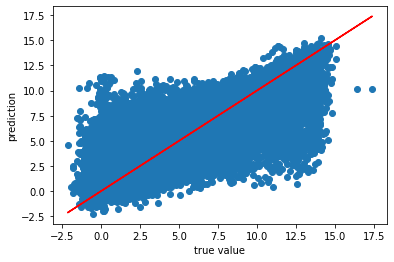

In [77]:
fit_and_eval(CatBoostRegressor(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 5.8 3JHN

Learning rate set to 0.088695
0:	learn: 1.2942049	total: 13.9ms	remaining: 13.9s
1:	learn: 1.2726231	total: 24.8ms	remaining: 12.4s
2:	learn: 1.2545801	total: 35.1ms	remaining: 11.7s
3:	learn: 1.2393551	total: 45.9ms	remaining: 11.4s
4:	learn: 1.2262773	total: 56.6ms	remaining: 11.3s
5:	learn: 1.2150108	total: 66.7ms	remaining: 11.1s
6:	learn: 1.2050018	total: 77.2ms	remaining: 10.9s
7:	learn: 1.1970114	total: 87.8ms	remaining: 10.9s
8:	learn: 1.1896607	total: 98ms	remaining: 10.8s
9:	learn: 1.1829647	total: 108ms	remaining: 10.6s
10:	learn: 1.1773119	total: 118ms	remaining: 10.6s
11:	learn: 1.1724139	total: 128ms	remaining: 10.5s
12:	learn: 1.1683313	total: 138ms	remaining: 10.5s
13:	learn: 1.1648602	total: 149ms	remaining: 10.5s
14:	learn: 1.1613429	total: 162ms	remaining: 10.6s
15:	learn: 1.1572648	total: 172ms	remaining: 10.6s
16:	learn: 1.1538089	total: 184ms	remaining: 10.6s
17:	learn: 1.1514208	total: 195ms	remaining: 10.6s
18:	learn: 1.1490319	total: 206ms	remaining: 10.6s
19:	

173:	learn: 1.0363615	total: 1.76s	remaining: 8.38s
174:	learn: 1.0357590	total: 1.77s	remaining: 8.37s
175:	learn: 1.0353220	total: 1.79s	remaining: 8.36s
176:	learn: 1.0349221	total: 1.79s	remaining: 8.35s
177:	learn: 1.0345537	total: 1.8s	remaining: 8.34s
178:	learn: 1.0338785	total: 1.81s	remaining: 8.33s
179:	learn: 1.0333536	total: 1.83s	remaining: 8.32s
180:	learn: 1.0328428	total: 1.84s	remaining: 8.31s
181:	learn: 1.0325300	total: 1.84s	remaining: 8.29s
182:	learn: 1.0319200	total: 1.86s	remaining: 8.29s
183:	learn: 1.0316447	total: 1.87s	remaining: 8.28s
184:	learn: 1.0313450	total: 1.88s	remaining: 8.27s
185:	learn: 1.0310065	total: 1.89s	remaining: 8.25s
186:	learn: 1.0304136	total: 1.9s	remaining: 8.24s
187:	learn: 1.0299140	total: 1.91s	remaining: 8.23s
188:	learn: 1.0293045	total: 1.91s	remaining: 8.21s
189:	learn: 1.0288957	total: 1.92s	remaining: 8.2s
190:	learn: 1.0285505	total: 1.93s	remaining: 8.19s
191:	learn: 1.0281449	total: 1.94s	remaining: 8.18s
192:	learn: 1.0

335:	learn: 0.9843208	total: 3.37s	remaining: 6.66s
336:	learn: 0.9840608	total: 3.38s	remaining: 6.66s
337:	learn: 0.9837909	total: 3.39s	remaining: 6.64s
338:	learn: 0.9836272	total: 3.4s	remaining: 6.63s
339:	learn: 0.9833747	total: 3.41s	remaining: 6.62s
340:	learn: 0.9832099	total: 3.42s	remaining: 6.61s
341:	learn: 0.9830009	total: 3.43s	remaining: 6.6s
342:	learn: 0.9827590	total: 3.44s	remaining: 6.59s
343:	learn: 0.9825341	total: 3.45s	remaining: 6.58s
344:	learn: 0.9821892	total: 3.46s	remaining: 6.57s
345:	learn: 0.9819629	total: 3.47s	remaining: 6.56s
346:	learn: 0.9815847	total: 3.48s	remaining: 6.55s
347:	learn: 0.9814161	total: 3.49s	remaining: 6.54s
348:	learn: 0.9811506	total: 3.5s	remaining: 6.53s
349:	learn: 0.9808562	total: 3.51s	remaining: 6.52s
350:	learn: 0.9806682	total: 3.52s	remaining: 6.51s
351:	learn: 0.9804620	total: 3.53s	remaining: 6.5s
352:	learn: 0.9803158	total: 3.54s	remaining: 6.49s
353:	learn: 0.9801814	total: 3.55s	remaining: 6.48s
354:	learn: 0.97

496:	learn: 0.9510797	total: 4.99s	remaining: 5.05s
497:	learn: 0.9509299	total: 5s	remaining: 5.04s
498:	learn: 0.9508067	total: 5.01s	remaining: 5.03s
499:	learn: 0.9506514	total: 5.02s	remaining: 5.02s
500:	learn: 0.9504739	total: 5.03s	remaining: 5.01s
501:	learn: 0.9503319	total: 5.04s	remaining: 5s
502:	learn: 0.9501960	total: 5.05s	remaining: 4.99s
503:	learn: 0.9500402	total: 5.06s	remaining: 4.98s
504:	learn: 0.9498500	total: 5.07s	remaining: 4.97s
505:	learn: 0.9497307	total: 5.08s	remaining: 4.96s
506:	learn: 0.9496177	total: 5.09s	remaining: 4.95s
507:	learn: 0.9494282	total: 5.1s	remaining: 4.94s
508:	learn: 0.9493292	total: 5.11s	remaining: 4.93s
509:	learn: 0.9492047	total: 5.12s	remaining: 4.92s
510:	learn: 0.9490485	total: 5.13s	remaining: 4.91s
511:	learn: 0.9487642	total: 5.14s	remaining: 4.89s
512:	learn: 0.9486082	total: 5.15s	remaining: 4.89s
513:	learn: 0.9484731	total: 5.16s	remaining: 4.88s
514:	learn: 0.9482935	total: 5.17s	remaining: 4.87s
515:	learn: 0.94812

656:	learn: 0.9240351	total: 6.6s	remaining: 3.45s
657:	learn: 0.9239145	total: 6.61s	remaining: 3.44s
658:	learn: 0.9237372	total: 6.62s	remaining: 3.43s
659:	learn: 0.9235345	total: 6.63s	remaining: 3.42s
660:	learn: 0.9233575	total: 6.64s	remaining: 3.41s
661:	learn: 0.9232563	total: 6.65s	remaining: 3.4s
662:	learn: 0.9231362	total: 6.66s	remaining: 3.39s
663:	learn: 0.9230414	total: 6.67s	remaining: 3.38s
664:	learn: 0.9228940	total: 6.68s	remaining: 3.37s
665:	learn: 0.9227062	total: 6.69s	remaining: 3.36s
666:	learn: 0.9224905	total: 6.7s	remaining: 3.35s
667:	learn: 0.9223369	total: 6.71s	remaining: 3.34s
668:	learn: 0.9222248	total: 6.72s	remaining: 3.33s
669:	learn: 0.9220715	total: 6.74s	remaining: 3.32s
670:	learn: 0.9219397	total: 6.74s	remaining: 3.31s
671:	learn: 0.9218321	total: 6.75s	remaining: 3.3s
672:	learn: 0.9215766	total: 6.76s	remaining: 3.29s
673:	learn: 0.9214859	total: 6.77s	remaining: 3.28s
674:	learn: 0.9213354	total: 6.78s	remaining: 3.27s
675:	learn: 0.92

817:	learn: 0.9015638	total: 8.21s	remaining: 1.83s
818:	learn: 0.9015094	total: 8.22s	remaining: 1.82s
819:	learn: 0.9013969	total: 8.23s	remaining: 1.81s
820:	learn: 0.9013196	total: 8.24s	remaining: 1.8s
821:	learn: 0.9011581	total: 8.26s	remaining: 1.79s
822:	learn: 0.9010418	total: 8.27s	remaining: 1.78s
823:	learn: 0.9009171	total: 8.28s	remaining: 1.77s
824:	learn: 0.9008245	total: 8.29s	remaining: 1.76s
825:	learn: 0.9007266	total: 8.29s	remaining: 1.75s
826:	learn: 0.9006004	total: 8.3s	remaining: 1.74s
827:	learn: 0.9004732	total: 8.31s	remaining: 1.73s
828:	learn: 0.9003574	total: 8.32s	remaining: 1.72s
829:	learn: 0.9002581	total: 8.33s	remaining: 1.71s
830:	learn: 0.9000686	total: 8.34s	remaining: 1.7s
831:	learn: 0.8999256	total: 8.35s	remaining: 1.69s
832:	learn: 0.8998429	total: 8.37s	remaining: 1.68s
833:	learn: 0.8997645	total: 8.37s	remaining: 1.67s
834:	learn: 0.8995501	total: 8.38s	remaining: 1.66s
835:	learn: 0.8993788	total: 8.39s	remaining: 1.65s
836:	learn: 0.8

977:	learn: 0.8820420	total: 9.82s	remaining: 221ms
978:	learn: 0.8819308	total: 9.83s	remaining: 211ms
979:	learn: 0.8818431	total: 9.84s	remaining: 201ms
980:	learn: 0.8816531	total: 9.85s	remaining: 191ms
981:	learn: 0.8815855	total: 9.86s	remaining: 181ms
982:	learn: 0.8814894	total: 9.87s	remaining: 171ms
983:	learn: 0.8813694	total: 9.88s	remaining: 161ms
984:	learn: 0.8812620	total: 9.89s	remaining: 151ms
985:	learn: 0.8811555	total: 9.9s	remaining: 141ms
986:	learn: 0.8810532	total: 9.91s	remaining: 131ms
987:	learn: 0.8809325	total: 9.92s	remaining: 121ms
988:	learn: 0.8808755	total: 9.93s	remaining: 110ms
989:	learn: 0.8808100	total: 9.94s	remaining: 100ms
990:	learn: 0.8806199	total: 9.95s	remaining: 90.4ms
991:	learn: 0.8805311	total: 9.96s	remaining: 80.3ms
992:	learn: 0.8804398	total: 9.97s	remaining: 70.3ms
993:	learn: 0.8803258	total: 9.98s	remaining: 60.3ms
994:	learn: 0.8802497	total: 9.99s	remaining: 50.2ms
995:	learn: 0.8801982	total: 10s	remaining: 40.2ms
996:	lear

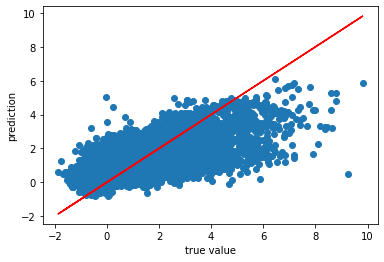

In [78]:
fit_and_eval(CatBoostRegressor(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

### 6. Neural Networks

In [55]:
def create_model(optimizer='adam', dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='linear',input_shape = (11,)))
    model.add(Dropout(dropout))
    model.add(Dense(64,activation='linear'))
    model.add(Dropout(dropout))
    model.add(Dense(64,activation='linear'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mean_absolute_error',optimizer=optimizer)

    return model

In [56]:
def nnet_preprocess(X_train, X_val):    
    # preprocess the dataset
    num_cols = []
    cat_cols = []
    
    for c in X_train.columns:
        if X_train[c].dtype in ['float64', 'int64']:
            num_cols.append(c)
        else:
            cat_cols.append(c)
    
    # Instantiate encoder/scaler
    scaler = MinMaxScaler()
    encoder = LabelEncoder()

    # Scale and Encode Separate Columns
    for i in num_cols:
        X_train[[i]] = scaler.fit_transform(X_train[[i]]) 
        X_val[[i]]  = scaler.transform(X_val[[i]]) 
    
    for f in cat_cols:
        X_train[f] = encoder.fit_transform(X_train[[f]])
        X_val[f] = encoder.transform(X_val[[f]])
    
    return X_train, X_val
    
    #processed_train = np.concatenate([train_scaled_columns, train_encoded_columns], axis=1)
    #processed_val = np.concatenate([val_scaled_columns, val_encoded_columns], axis=1)
    

In [84]:
def fit_eval_nn(X_train, y_train, X_val, y_val, epoch, batch):
    model = Sequential()
    model.add(Dense(64,activation='relu',input_shape = (13,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='relu'))

    model.compile(loss='mean_squared_error',optimizer= 'adam', metrics=['mae'])
    
    X_train, X_val = nnet_preprocess(X_train, X_val)
    #fit model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs = epoch, 
                        batch_size = batch)
    
    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Validation MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    print('')
    print('Prediction')
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')
    plt.show()
    print('')
    print('Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

#### 6.1 1JHC

Epoch 1/100
17729/17729 [==============================] - 23s 1ms/step - loss: 350.0128 - mae: 11.1340 - val_loss: 68.5791 - val_mae: 5.5782
Epoch 2/100
17729/17729 [==============================] - 23s 1ms/step - loss: 109.2264 - mae: 7.8451 - val_loss: 76.3665 - val_mae: 5.7621
Epoch 3/100
17729/17729 [==============================] - 22s 1ms/step - loss: 105.8451 - mae: 7.7326 - val_loss: 66.0076 - val_mae: 5.5283
Epoch 4/100
17729/17729 [==============================] - 22s 1ms/step - loss: 103.9001 - mae: 7.6522 - val_loss: 72.9905 - val_mae: 5.5622
Epoch 5/100
17729/17729 [==============================] - 24s 1ms/step - loss: 101.9797 - mae: 7.5773 - val_loss: 83.1012 - val_mae: 5.7585
Epoch 6/100
17729/17729 [==============================] - 23s 1ms/step - loss: 100.1283 - mae: 7.4986 - val_loss: 78.2179 - val_mae: 5.6610
Epoch 7/100
17729/17729 [==============================] - 22s 1ms/step - loss: 99.8303 - mae: 7.4684 - val_loss: 133.0577 - val_mae: 6.4005
Epoch 8/100


17729/17729 [==============================] - 22s 1ms/step - loss: 71.0442 - mae: 6.1118 - val_loss: 72.3335 - val_mae: 5.5757
Epoch 60/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.8999 - mae: 6.1086 - val_loss: 74.6068 - val_mae: 5.5362
Epoch 61/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.6242 - mae: 6.1035 - val_loss: 107.1879 - val_mae: 5.9313
Epoch 62/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.7405 - mae: 6.0978 - val_loss: 88.2849 - val_mae: 5.7032
Epoch 63/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.5073 - mae: 6.0944 - val_loss: 92.8011 - val_mae: 5.8025
Epoch 64/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.0016 - mae: 6.0690 - val_loss: 74.0593 - val_mae: 5.5537
Epoch 65/100
17729/17729 [==============================] - 22s 1ms/step - loss: 70.4015 - mae: 6.0771 - val_loss: 77.5027 - val_mae: 5.6268
Epoch 66/100
17729/17729 

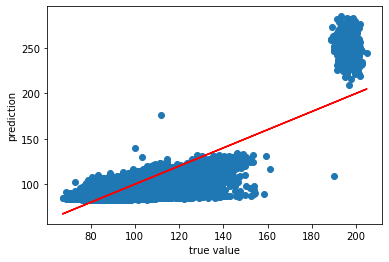


Loss


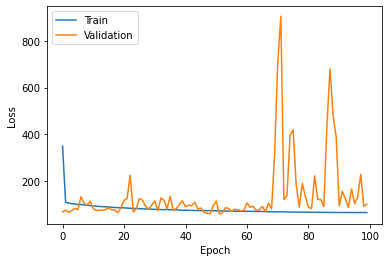

In [85]:
fit_eval_nn(c1_X_train, c1_y_train, c1_X_val, c1_y_val, epoch = 100, batch = 32)

#### 6.2 1JHN

Epoch 1/100
1092/1092 [==============================] - 1s 1ms/step - loss: 619.6322 - mae: 18.8711 - val_loss: 69.5251 - val_mae: 5.3651
Epoch 2/100
1092/1092 [==============================] - 1s 988us/step - loss: 62.6683 - mae: 5.8005 - val_loss: 21.2626 - val_mae: 3.1210
Epoch 3/100
1092/1092 [==============================] - 1s 999us/step - loss: 39.5320 - mae: 4.8252 - val_loss: 18.6580 - val_mae: 3.0078
Epoch 4/100
1092/1092 [==============================] - 1s 1ms/step - loss: 34.8217 - mae: 4.5585 - val_loss: 20.3626 - val_mae: 3.1212
Epoch 5/100
1092/1092 [==============================] - 1s 1ms/step - loss: 33.4117 - mae: 4.4466 - val_loss: 22.9261 - val_mae: 3.2133
Epoch 6/100
1092/1092 [==============================] - 1s 1ms/step - loss: 31.9222 - mae: 4.3369 - val_loss: 18.0127 - val_mae: 2.9455
Epoch 7/100
1092/1092 [==============================] - 1s 999us/step - loss: 32.2090 - mae: 4.3491 - val_loss: 19.4239 - val_mae: 3.1814
Epoch 8/100
1092/1092 [==========

1092/1092 [==============================] - 1s 1000us/step - loss: 26.8419 - mae: 3.9535 - val_loss: 18.4837 - val_mae: 2.9089
Epoch 61/100
1092/1092 [==============================] - 1s 989us/step - loss: 26.4734 - mae: 3.9268 - val_loss: 18.6539 - val_mae: 2.8645
Epoch 62/100
1092/1092 [==============================] - 1s 985us/step - loss: 26.6485 - mae: 3.9327 - val_loss: 19.9482 - val_mae: 2.9544
Epoch 63/100
1092/1092 [==============================] - 1s 989us/step - loss: 26.0974 - mae: 3.8855 - val_loss: 18.8610 - val_mae: 2.9226
Epoch 64/100
1092/1092 [==============================] - 1s 989us/step - loss: 26.6828 - mae: 3.9292 - val_loss: 18.1546 - val_mae: 2.8101
Epoch 65/100
1092/1092 [==============================] - 1s 996us/step - loss: 26.1482 - mae: 3.9013 - val_loss: 18.0467 - val_mae: 2.8673
Epoch 66/100
1092/1092 [==============================] - 1s 994us/step - loss: 26.3024 - mae: 3.9106 - val_loss: 18.4047 - val_mae: 2.8700
Epoch 67/100
1092/1092 [========

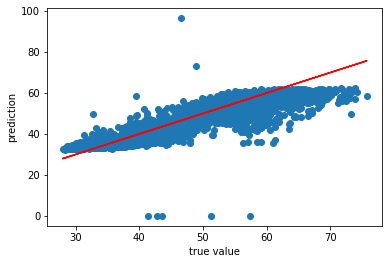


Loss


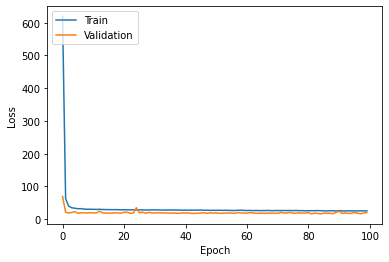

In [86]:
fit_eval_nn(n1_X_train, n1_y_train, n1_X_val, n1_y_val, epoch = 100, batch = 32)

#### 6.3 2JHC

Epoch 1/100
28522/28522 [==============================] - 40s 1ms/step - loss: 18.6950 - mae: 2.8571 - val_loss: 17.9359 - val_mae: 2.7706
Epoch 2/100
28522/28522 [==============================] - 39s 1ms/step - loss: 18.0787 - mae: 2.8250 - val_loss: 18.0265 - val_mae: 2.7612
Epoch 3/100
28522/28522 [==============================] - 39s 1ms/step - loss: 17.8542 - mae: 2.8119 - val_loss: 17.9126 - val_mae: 2.7242
Epoch 4/100
28522/28522 [==============================] - 39s 1ms/step - loss: 17.8520 - mae: 2.8092 - val_loss: 16.9044 - val_mae: 2.7512
Epoch 5/100
28522/28522 [==============================] - 39s 1ms/step - loss: 17.8620 - mae: 2.8112 - val_loss: 18.1181 - val_mae: 2.7112
Epoch 6/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.7799 - mae: 2.8072 - val_loss: 16.9862 - val_mae: 2.7920
Epoch 7/100
28522/28522 [==============================] - 39s 1ms/step - loss: 17.7497 - mae: 2.8051 - val_loss: 17.1783 - val_mae: 2.7322
Epoch 8/100
28522/28

28522/28522 [==============================] - 38s 1ms/step - loss: 17.5615 - mae: 2.7932 - val_loss: 66.6804 - val_mae: 3.0173
Epoch 60/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.5746 - mae: 2.7928 - val_loss: 22.1445 - val_mae: 2.7947
Epoch 61/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.6561 - mae: 2.7997 - val_loss: 36.6316 - val_mae: 2.8544
Epoch 62/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.5520 - mae: 2.7929 - val_loss: 29.5909 - val_mae: 2.8573
Epoch 63/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.5702 - mae: 2.7940 - val_loss: 23.6067 - val_mae: 2.8251
Epoch 64/100
28522/28522 [==============================] - 38s 1ms/step - loss: 17.4977 - mae: 2.7884 - val_loss: 39.6776 - val_mae: 2.9156
Epoch 65/100
28522/28522 [==============================] - 39s 1ms/step - loss: 17.5531 - mae: 2.7934 - val_loss: 23.7464 - val_mae: 2.8196
Epoch 66/100
28522/28522 [

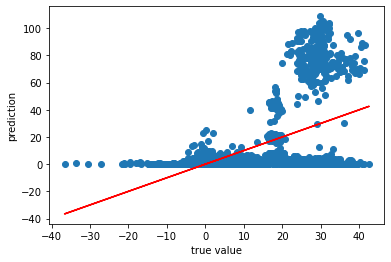


Loss


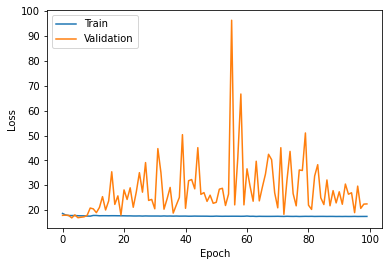

In [87]:
fit_eval_nn(c2_X_train, c2_y_train, c2_X_val, c2_y_val, epoch = 100, batch = 32)

#### 6.4 2JHH

Epoch 1/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.7732 - mae: 10.5285 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 2/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6991 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 3/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6989 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 4/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6988 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 5/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6990 - mae: 10.5250 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 6/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6989 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 7/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6991 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 

9450/9450 [==============================] - 13s 1ms/step - loss: 121.6987 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 59/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6987 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 60/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6989 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 61/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6989 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 62/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6987 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 63/100
9450/9450 [==============================] - 13s 1ms/step - loss: 121.6987 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 64/100
9450/9450 [==============================] - 12s 1ms/step - loss: 121.6989 - mae: 10.5251 - val_loss: 121.1630 - val_mae: 10.4865
Epoch 65/100

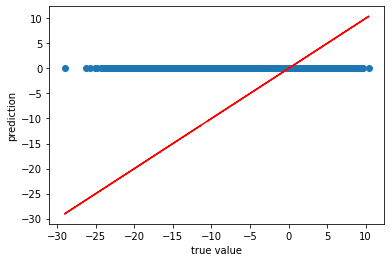


Loss


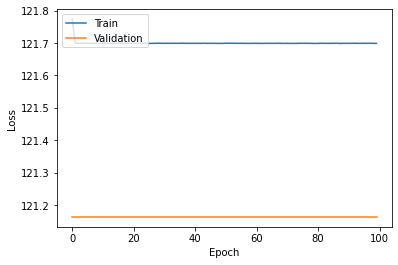

In [88]:
fit_eval_nn(h2_X_train, h2_y_train, h2_X_val, h2_y_val, epoch = 100, batch = 32)

#### 6.5 2JHN

Epoch 1/100
2977/2977 [==============================] - 4s 1ms/step - loss: 10.8329 - mae: 2.5304 - val_loss: 9.1442 - val_mae: 2.3192
Epoch 2/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.7549 - mae: 2.4168 - val_loss: 8.6467 - val_mae: 2.2829
Epoch 3/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.4867 - mae: 2.3769 - val_loss: 9.0863 - val_mae: 2.2785
Epoch 4/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.3766 - mae: 2.3561 - val_loss: 8.5841 - val_mae: 2.2321
Epoch 5/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.2564 - mae: 2.3341 - val_loss: 8.5952 - val_mae: 2.2453
Epoch 6/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.1559 - mae: 2.3202 - val_loss: 8.2080 - val_mae: 2.1748
Epoch 7/100
2977/2977 [==============================] - 4s 1ms/step - loss: 9.0597 - mae: 2.3005 - val_loss: 8.1415 - val_mae: 2.1289
Epoch 8/100
2977/2977 [==============================]

2977/2977 [==============================] - 4s 1ms/step - loss: 8.5355 - mae: 2.1992 - val_loss: 7.7776 - val_mae: 2.0477
Epoch 62/100
2977/2977 [==============================] - 4s 1ms/step - loss: 8.5253 - mae: 2.1957 - val_loss: 7.4954 - val_mae: 2.0271
Epoch 63/100
2977/2977 [==============================] - 4s 1ms/step - loss: 8.4778 - mae: 2.1903 - val_loss: 7.4800 - val_mae: 2.0143
Epoch 64/100
2977/2977 [==============================] - 4s 1ms/step - loss: 8.4599 - mae: 2.1870 - val_loss: 7.2639 - val_mae: 1.9888
Epoch 65/100
2977/2977 [==============================] - 4s 1ms/step - loss: 8.4865 - mae: 2.1895 - val_loss: 7.4082 - val_mae: 2.0126
Epoch 66/100
2977/2977 [==============================] - 5s 2ms/step - loss: 8.4295 - mae: 2.1842 - val_loss: 7.6540 - val_mae: 2.0806
Epoch 67/100
2977/2977 [==============================] - 4s 1ms/step - loss: 8.4648 - mae: 2.1885 - val_loss: 7.4159 - val_mae: 2.0261
Epoch 68/100
2977/2977 [==============================] - 5s 

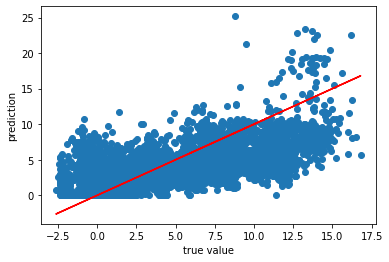


Loss


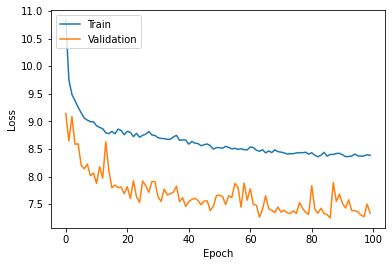

In [89]:
fit_eval_nn(n2_X_train, n2_y_train, n2_X_val, n2_y_val, epoch = 100, batch = 32)

#### 6.6 3JHC

Epoch 1/100
37781/37781 [==============================] - 52s 1ms/step - loss: 7.3596 - mae: 2.0509 - val_loss: 6.7827 - val_mae: 1.9559
Epoch 2/100
37781/37781 [==============================] - 55s 1ms/step - loss: 7.1026 - mae: 2.0084 - val_loss: 6.8348 - val_mae: 1.9552
Epoch 3/100
37781/37781 [==============================] - 52s 1ms/step - loss: 7.0700 - mae: 2.0022 - val_loss: 6.7273 - val_mae: 1.9357
Epoch 4/100
37781/37781 [==============================] - 53s 1ms/step - loss: 7.0213 - mae: 1.9947 - val_loss: 6.7141 - val_mae: 1.9195
Epoch 5/100
37781/37781 [==============================] - 58s 2ms/step - loss: 7.0052 - mae: 1.9920 - val_loss: 6.6164 - val_mae: 1.9146
Epoch 6/100
37781/37781 [==============================] - 52s 1ms/step - loss: 6.9854 - mae: 1.9885 - val_loss: 6.5843 - val_mae: 1.9198
Epoch 7/100
37781/37781 [==============================] - 55s 1ms/step - loss: 6.9739 - mae: 1.9866 - val_loss: 6.6041 - val_mae: 1.9078
Epoch 8/100
37781/37781 [=========

37781/37781 [==============================] - 53s 1ms/step - loss: 6.8625 - mae: 1.9659 - val_loss: 6.4705 - val_mae: 1.8860
Epoch 61/100
37781/37781 [==============================] - 59s 2ms/step - loss: 6.8646 - mae: 1.9667 - val_loss: 6.4067 - val_mae: 1.8747
Epoch 62/100
37781/37781 [==============================] - 51s 1ms/step - loss: 6.8610 - mae: 1.9664 - val_loss: 6.4626 - val_mae: 1.8863
Epoch 63/100
37781/37781 [==============================] - 55s 1ms/step - loss: 6.8611 - mae: 1.9660 - val_loss: 6.4257 - val_mae: 1.8720
Epoch 64/100
37781/37781 [==============================] - 50s 1ms/step - loss: 6.8546 - mae: 1.9649 - val_loss: 6.4881 - val_mae: 1.8905
Epoch 65/100
37781/37781 [==============================] - 55s 1ms/step - loss: 6.8642 - mae: 1.9669 - val_loss: 6.4517 - val_mae: 1.8856
Epoch 66/100
37781/37781 [==============================] - 59s 2ms/step - loss: 6.8725 - mae: 1.9689 - val_loss: 6.4664 - val_mae: 1.8913
Epoch 67/100
37781/37781 [==============

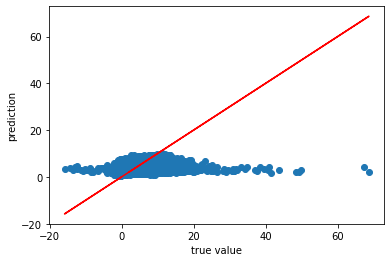


Loss


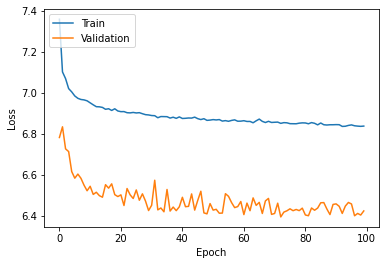

In [90]:
fit_eval_nn(c3_X_train, c3_y_train, c3_X_val, c3_y_val, epoch = 100, batch = 32)

#### 6.7 3JHH

Epoch 1/100
14764/14764 [==============================] - 23s 2ms/step - loss: 8.9220 - mae: 2.2328 - val_loss: 6.4984 - val_mae: 1.8715
Epoch 2/100
14764/14764 [==============================] - 22s 1ms/step - loss: 7.5228 - mae: 2.0491 - val_loss: 6.9033 - val_mae: 1.9122
Epoch 3/100
14764/14764 [==============================] - 21s 1ms/step - loss: 7.3590 - mae: 2.0229 - val_loss: 6.0197 - val_mae: 1.7320
Epoch 4/100
14764/14764 [==============================] - 20s 1ms/step - loss: 6.9791 - mae: 1.9657 - val_loss: 5.4989 - val_mae: 1.6914
Epoch 5/100
14764/14764 [==============================] - 22s 1ms/step - loss: 6.9213 - mae: 1.9557 - val_loss: 5.6251 - val_mae: 1.7135
Epoch 6/100
14764/14764 [==============================] - 22s 2ms/step - loss: 6.8736 - mae: 1.9498 - val_loss: 6.0245 - val_mae: 1.7850
Epoch 7/100
14764/14764 [==============================] - 20s 1ms/step - loss: 6.8228 - mae: 1.9444 - val_loss: 5.6830 - val_mae: 1.7364
Epoch 8/100
14764/14764 [=========

14764/14764 [==============================] - 22s 1ms/step - loss: 6.9802 - mae: 1.9712 - val_loss: 6.2479 - val_mae: 1.8462
Epoch 61/100
14764/14764 [==============================] - 22s 2ms/step - loss: 7.3162 - mae: 2.0223 - val_loss: 6.3209 - val_mae: 1.8859
Epoch 62/100
14764/14764 [==============================] - 23s 2ms/step - loss: 7.2925 - mae: 2.0182 - val_loss: 6.1177 - val_mae: 1.8259
Epoch 63/100
14764/14764 [==============================] - 23s 2ms/step - loss: 7.2604 - mae: 2.0120 - val_loss: 6.2294 - val_mae: 1.8506
Epoch 64/100
14764/14764 [==============================] - 23s 2ms/step - loss: 7.2386 - mae: 2.0104 - val_loss: 6.2914 - val_mae: 1.8779
Epoch 65/100
14764/14764 [==============================] - 23s 2ms/step - loss: 7.2176 - mae: 2.0065 - val_loss: 6.1476 - val_mae: 1.8092
Epoch 66/100
14764/14764 [==============================] - 23s 2ms/step - loss: 7.2150 - mae: 2.0064 - val_loss: 6.1507 - val_mae: 1.8328
Epoch 67/100
14764/14764 [==============

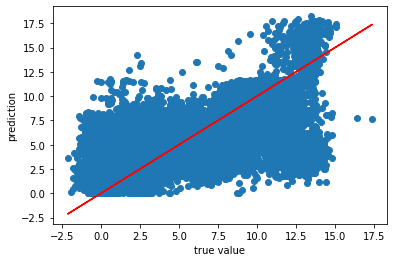


Loss


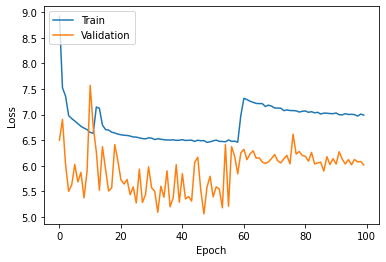

In [91]:
fit_eval_nn(h3_X_train, h3_y_train, h3_X_val, h3_y_val, epoch = 100, batch = 32)

#### 6.8 3JHN

Epoch 1/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.5937 - mae: 0.9065 - val_loss: 1.4041 - val_mae: 0.8146
Epoch 2/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.4212 - mae: 0.8481 - val_loss: 1.3353 - val_mae: 0.8144
Epoch 3/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.3968 - mae: 0.8371 - val_loss: 1.3458 - val_mae: 0.7999
Epoch 4/100
4166/4166 [==============================] - 5s 1ms/step - loss: 1.3867 - mae: 0.8334 - val_loss: 1.3097 - val_mae: 0.8005
Epoch 5/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.3770 - mae: 0.8292 - val_loss: 1.2901 - val_mae: 0.7918
Epoch 6/100
4166/4166 [==============================] - 7s 2ms/step - loss: 1.3710 - mae: 0.8281 - val_loss: 1.2872 - val_mae: 0.7847
Epoch 7/100
4166/4166 [==============================] - 7s 2ms/step - loss: 1.3713 - mae: 0.8281 - val_loss: 1.2877 - val_mae: 0.7815
Epoch 8/100
4166/4166 [==============================] 

4166/4166 [==============================] - 6s 1ms/step - loss: 1.3189 - mae: 0.8104 - val_loss: 1.2157 - val_mae: 0.7601
Epoch 62/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.3129 - mae: 0.8075 - val_loss: 1.2129 - val_mae: 0.7545
Epoch 63/100
4166/4166 [==============================] - 5s 1ms/step - loss: 1.3095 - mae: 0.8071 - val_loss: 1.1828 - val_mae: 0.7589
Epoch 64/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.3154 - mae: 0.8092 - val_loss: 1.1767 - val_mae: 0.7538
Epoch 65/100
4166/4166 [==============================] - 6s 2ms/step - loss: 1.3133 - mae: 0.8094 - val_loss: 1.1920 - val_mae: 0.7498
Epoch 66/100
4166/4166 [==============================] - 7s 2ms/step - loss: 1.3147 - mae: 0.8079 - val_loss: 1.1753 - val_mae: 0.7493
Epoch 67/100
4166/4166 [==============================] - 6s 1ms/step - loss: 1.3114 - mae: 0.8082 - val_loss: 1.2070 - val_mae: 0.7584
Epoch 68/100
4166/4166 [==============================] - 6s 

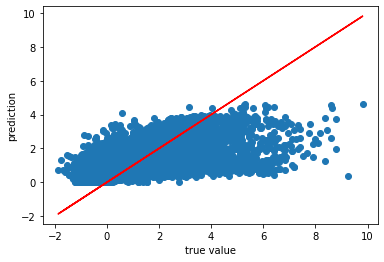


Loss


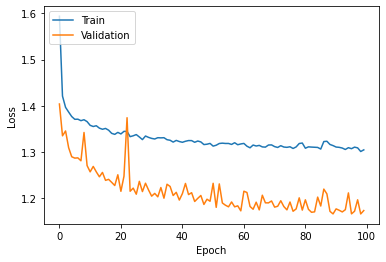

In [92]:
fit_eval_nn(n3_X_train, n3_y_train, n3_X_val, n3_y_val, epoch = 100, batch = 32)